# Results
<hr style="clear:both">

This notebook presents our results for the ADA Milestone 3 project. More precisely, we present how we created our success metric, how we computed past "golden age" for each genre and how we used impact time series to make future predictions. For better comprehension of the different techniques such as the prediction method, see the `methods.ipynb` notebook.


**Project Mentor:** [Shuo Wen](http://personnes.epfl.ch/shuo.wen) ([Email](shuo.wen@epfl.ch)),
**Authors:** Mahmoud Dokmak, Matthieu Borello, Léo Brunneau, Loïc Domingos, Bastien Armstrong

<hr style="clear:both">

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats
import dash
import warnings

from dash.dependencies import Input, Output
from src.models.Impact import impact_genre
from src.models.PolynomialRegression import polynomial_regression
from src.models.ARIMA import arima
from src.utils.print_prediction import plot_results
from src.utils.results_utils import *
from matplotlib import pyplot as plt
from typing import final
from dash import dcc, html
from ipywidgets import interact
from IPython.display import Image, display
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')

# Success Metric
Now we have collected all the data we need, we can now create our success metric. This metric is based on the popularity score, the box office revenue (inflation adjusted), the average rating, and the reviews sentiment analysis score. Of course, we needed to assign each of these components a weight. After lots of testing, we found the best weight combinations:
- Popularity score: 10
- Box office revenue: 8
- Average rating: 3
- Reviews sentiment analysis score: 3
This combination makes it a very good metric to evaluate the success of a movie. The average rating and the reviews sentiment analysis score take less importance than the popularity score and the box office revenue because they are already taken into account in a way in the TMDB popularity score, and most movies don’t have a large number of voters.

This combination makes it a very good metric to evaluate the success of a movie. The average rating and the reviews sentiment analysis score take less importance than the popularity score and the box office revenue because they are already taken into account in a way in the TMDB popularity score, and most movies don’t have a large number of voters.

We think that the popularity score and the box office revenue are the most important factors to evaluate the success of a movie. The reviews sentiment analysis score and the average rating are less important because they are more subjective and can be biased.

We wanted to include as many movies as possible, so the reader can relate to the results. Instead of removing movies with missing data, we decided to fill in the missing values with the mean of the respective column. This approach works well, as we observed that the column averages naturally penalize the movies slightly but still maintain the balance of the dataset. We ensured that the popularity metric was available for all movies, which by itself is a very good indicator of the success of a movie.

Finally, by inspection, we found that our success metric works very well. It provides a good ranking of the movies, and the movies that we know are successful are ranked high on the list.

In [3]:
data_box_office = pd.read_pickle('./data/Data_For_Score.pkl')

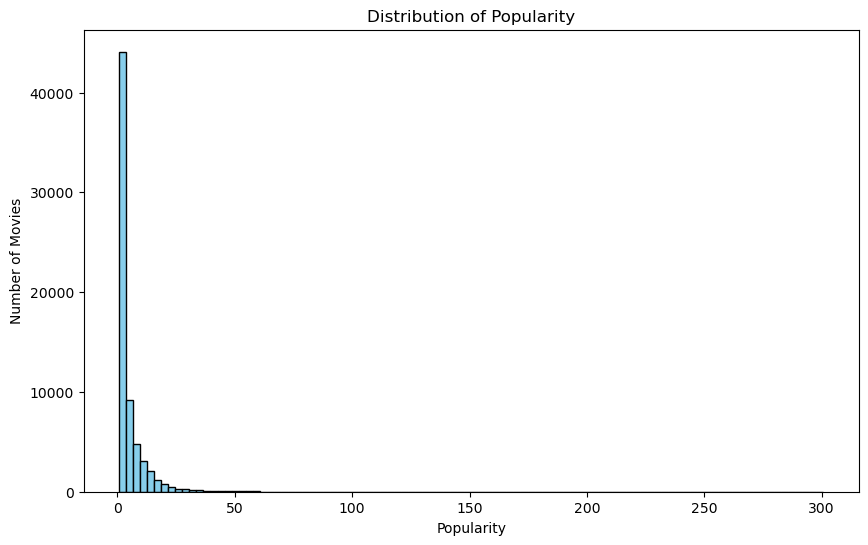

In [4]:
# Let's explore the TMDB popularity distribution
plt.figure(figsize=(10, 6))
plt.hist(data_box_office['popularity'],bins=100,color='skyblue',edgecolor='black')
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Movies')
plt.show()

In [5]:
data_box_office[data_box_office['popularity'] > 28].shape

(1037, 14)

Here we see that the popularity metric is unbounded but only 1000 movies have popularity score above 28. We will clip the popularity score to 28 so we can have a nicer distribution and we can standardize the data more accurately.

In [6]:
data_box_office['popularity'] = data_box_office['popularity'].clip(upper=28)

In [7]:
# We normalize the columns we are going to use to compute our success metric using a scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_normalize = ['avgRating', 'vote_average', 'popularity', 'Box_Office', 'inflation_adjusted_box_office_revenue']
data_box_office[columns_to_normalize] = scaler.fit_transform(data_box_office[columns_to_normalize])

In [8]:
# Penalize ratings with low number of votes
data_box_office["vote_avg"] = data_box_office.apply(
    lambda row: max(0, row["vote_average"] - 0.5 ** row["vote_count"]), axis=1
)
columns_to_drop = ['vote_average', 'vote_count']
data_box_office = data_box_office.drop(columns=columns_to_drop)
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,avgRating,popularity,vote_avg
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,0.014377,0.013326,United States of America,"Thriller, Cold War, Action/Adventure, Drama, W...",NaN,NaN,1.0,0.607579
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,0.833940,0.274440,United States of America,"Science Fiction, Action, Fantasy, Adventure",NaN,NaN,1.0,0.753053
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,NaN,NaN,Italy,"Softcore Porn, Comedy, World cinema, Adult",0.777778,0.649573,1.0,0.452632
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,NaN,NaN,United States of America,"Thriller, Horror, Slasher, Psychological thriller",0.257778,0.330596,1.0,0.421053
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,0.350345,0.190522,"United States of America, United Kingdom","Fantasy Adventure, Adventure, Children's/Famil...",0.639775,0.708489,1.0,0.780632


In [9]:
# Combine the ratings
data_box_office = combine_ratings(data_box_office)
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,0.014377,0.013326,United States of America,"Thriller, Cold War, Action/Adventure, Drama, W...",NaN,1.0,0.607579
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,0.833940,0.274440,United States of America,"Science Fiction, Action, Fantasy, Adventure",NaN,1.0,0.753053
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,NaN,NaN,Italy,"Softcore Porn, Comedy, World cinema, Adult",0.777778,1.0,0.551102
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,NaN,NaN,United States of America,"Thriller, Horror, Slasher, Psychological thriller",0.257778,1.0,0.375824
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,0.350345,0.190522,"United States of America, United Kingdom","Fantasy Adventure, Adventure, Children's/Famil...",0.639775,1.0,0.744560


In [10]:
# Replace 0 with NaN in the 'popularity' and 'rating' columns
data_box_office['rating'] = data_box_office['rating'].replace(0, np.nan)
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,0.014377,0.013326,United States of America,"Thriller, Cold War, Action/Adventure, Drama, W...",NaN,1.0,0.607579
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,0.833940,0.274440,United States of America,"Science Fiction, Action, Fantasy, Adventure",NaN,1.0,0.753053
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,NaN,NaN,Italy,"Softcore Porn, Comedy, World cinema, Adult",0.777778,1.0,0.551102
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,NaN,NaN,United States of America,"Thriller, Horror, Slasher, Psychological thriller",0.257778,1.0,0.375824
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,0.350345,0.190522,"United States of America, United Kingdom","Fantasy Adventure, Adventure, Children's/Famil...",0.639775,1.0,0.744560


In [11]:
# Filling the missing values with the mean of the column
columns_to_fill = ['rating', 'sa_score', 'inflation_adjusted_box_office_revenue', 'Box_Office']
data_box_office[columns_to_fill] = data_box_office[columns_to_fill].fillna(data_box_office[columns_to_fill].mean())
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,0.014377,0.013326,United States of America,"Thriller, Cold War, Action/Adventure, Drama, W...",0.634957,1.0,0.607579
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,0.833940,0.274440,United States of America,"Science Fiction, Action, Fantasy, Adventure",0.634957,1.0,0.753053
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,0.014450,0.009824,Italy,"Softcore Porn, Comedy, World cinema, Adult",0.777778,1.0,0.551102
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,0.014450,0.009824,United States of America,"Thriller, Horror, Slasher, Psychological thriller",0.257778,1.0,0.375824
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,0.350345,0.190522,"United States of America, United Kingdom","Fantasy Adventure, Adventure, Children's/Famil...",0.639775,1.0,0.744560


In [12]:
# item_id is not important for our analysis
data_box_office.isna().sum()

freebase_movie_id                            0
imdb_id                                      0
item_id                                  52369
movie_name                                   0
combined_release_date                        0
Box_Office                                   0
inflation_adjusted_box_office_revenue        0
movie_countries_final                        0
movie_genres_final                           0
sa_score                                     0
popularity                                   0
rating                                       0
dtype: int64

In [13]:
# Compute the success score on our dataframe
data_box_office = success(data_box_office, 'popularity', 'inflation_adjusted_box_office_revenue', 'sa_score', 'rating')
best_succes_movies = data_box_office
best_succes_movies

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,0.143767,0.996126,United States of America,"Film adaptation, Costume drama, Roadshow theat...",0.634957,1.000000,0.785789,22.231248,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,0.149518,1.000000,United States of America,"Romance Film, Musical, Fantasy, Family Film, A...",0.634957,1.000000,0.696421,21.994133,4.944084
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,0.096125,0.567962,United States of America,"Adventure, Children's/Family, Animation, Comin...",0.634957,1.000000,0.684211,18.501200,4.120385
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,0.278692,0.442916,United States of America,"Science Fiction, Adventure, Fantasy, Coming of...",0.634957,1.000000,0.810947,17.881039,3.974139
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,0.785462,0.471324,United States of America,"Tragedy, Costume drama, Historical fiction, Ac...",0.592075,1.000000,0.714080,17.689057,3.928867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38726,/m/0bbvvk0,131624,132640.0,UFO: Target Earth,1974-09-01,0.014450,0.009824,United States of America,Science Fiction,0.115385,0.022336,0.165594,1.144886,0.027442
2401,/m/0fqqm2h,195039,91960.0,The Magic Christmas Tree,1964-12-19,0.014450,0.009824,United States of America,"Family Film, Fantasy",0.200000,0.006314,0.121412,1.105968,0.018265
12696,/m/05pcssh,902274,157093.0,Death on Demand,2008-01-01,0.014450,0.009824,United States of America,"B-movie, Horror, Slasher, Haunted House Film",0.111111,0.000000,0.222222,1.078594,0.011809
39504,/m/05f965s,120200,176195.0,Starquest II,1996-01-01,0.014450,0.009824,United States of America,"Thriller, Science Fiction",0.055556,0.048796,0.107977,1.057147,0.006752


In [14]:
# Adjust the columns order
desired_order = ['freebase_movie_id', 'imdb_id', 'item_id', 'movie_name', 'combined_release_date', 'movie_countries_final', 'movie_genres_final', 'Box_Office', 'inflation_adjusted_box_office_revenue',  'sa_score', 'rating', 'popularity', 'success_score', 'success_metric_scaled']
best_succes_movies = best_succes_movies.reindex(columns=desired_order)
best_succes_movies.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,movie_countries_final,movie_genres_final,Box_Office,inflation_adjusted_box_office_revenue,sa_score,rating,popularity,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,United States of America,"Film adaptation, Costume drama, Roadshow theat...",0.143767,0.996126,0.634957,0.785789,1.0,22.231248,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,United States of America,"Romance Film, Musical, Fantasy, Family Film, A...",0.149518,1.000000,0.634957,0.696421,1.0,21.994133,4.944084
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,United States of America,"Adventure, Children's/Family, Animation, Comin...",0.096125,0.567962,0.634957,0.684211,1.0,18.501200,4.120385
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,United States of America,"Science Fiction, Adventure, Fantasy, Coming of...",0.278692,0.442916,0.634957,0.810947,1.0,17.881039,3.974139
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,United States of America,"Tragedy, Costume drama, Historical fiction, Ac...",0.785462,0.471324,0.592075,0.714080,1.0,17.689057,3.928867


In [15]:
best_succes_movies.to_pickle('./data/Success_Metric.pkl')

## Now let's analyze

In [100]:
# We reload the data for the nest parts
movies = pd.read_pickle('./data/Success_Metric.pkl')
movies.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,movie_countries_final,movie_genres_final,Box_Office,inflation_adjusted_box_office_revenue,sa_score,rating,popularity,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,United States of America,"Film adaptation, Costume drama, Roadshow theat...",0.143767,0.996126,0.634957,0.785789,1.0,22.231248,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,United States of America,"Romance Film, Musical, Fantasy, Family Film, A...",0.149518,1.000000,0.634957,0.696421,1.0,21.994133,4.944084
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,United States of America,"Adventure, Children's/Family, Animation, Comin...",0.096125,0.567962,0.634957,0.684211,1.0,18.501200,4.120385
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,United States of America,"Science Fiction, Adventure, Fantasy, Coming of...",0.278692,0.442916,0.634957,0.810947,1.0,17.881039,3.974139
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,United States of America,"Tragedy, Costume drama, Historical fiction, Ac...",0.785462,0.471324,0.592075,0.714080,1.0,17.689057,3.928867


First of all, let's display the 20 movies with the most success in history

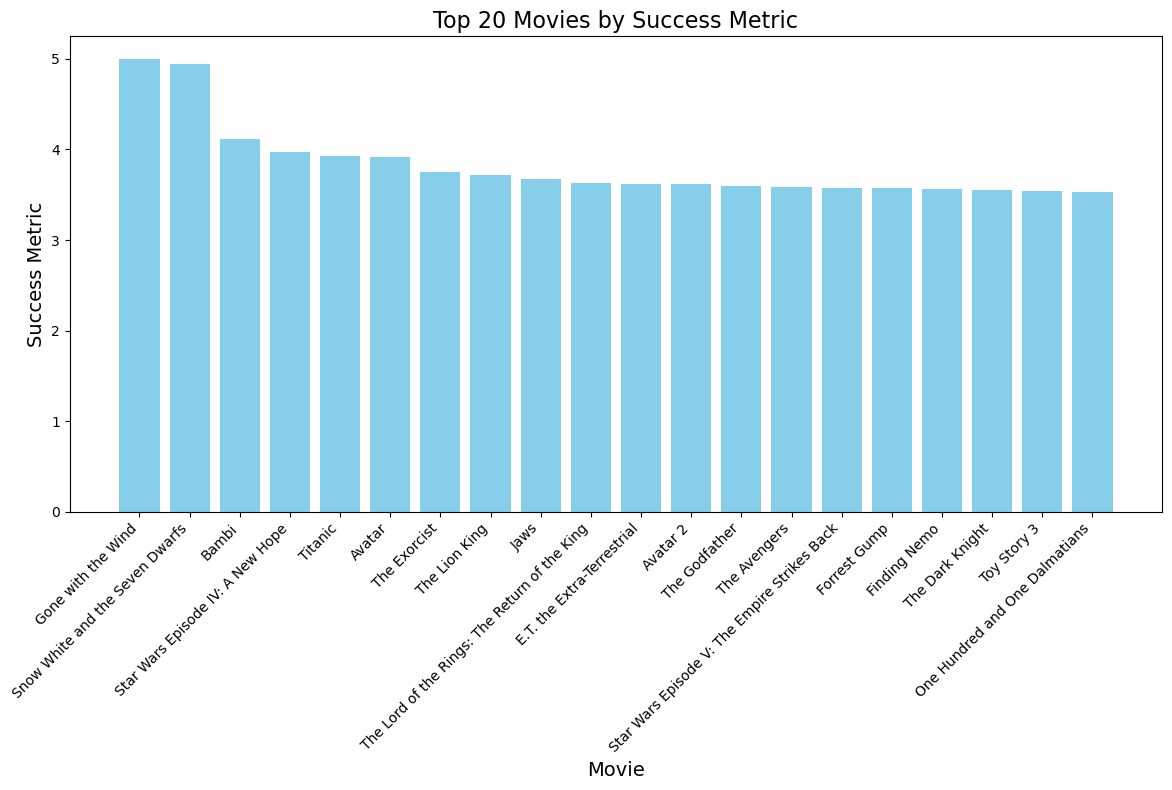

In [101]:
# Sort the by success the movies and select the 20 most successful movies
most_successful = movies.sort_values(by='success_metric_scaled', ascending=False)
top_20_movies = most_successful.head(20)
# Bar Chart
plt.figure(figsize=(12, 8))
plt.bar(
    top_20_movies['movie_name'],  # Movie names
    top_20_movies['success_metric_scaled'],  # Success metric
    color='skyblue'
)

plt.title('Top 20 Movies by Success Metric', fontsize=16)
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Success Metric', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('./plots/20movies.png', dpi=300, bbox_inches='tight')
plt.show()


Let's display the distribution of our success metric.

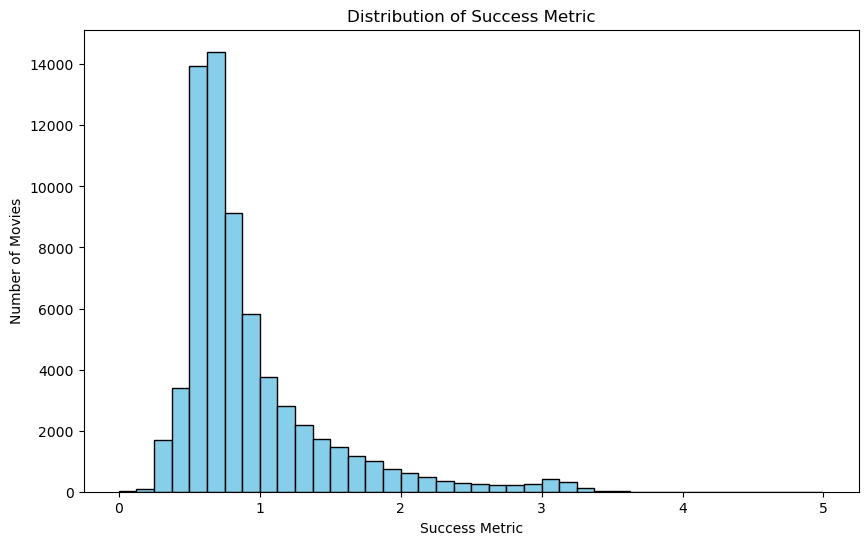

In [102]:
# Histogram of the Success_metric
plt.figure(figsize=(10, 6))
plt.hist(movies['success_metric_scaled'].dropna(), bins=40, color='skyblue', edgecolor='black')
plt.title('Distribution of Success Metric')
plt.xlabel('Success Metric')
plt.ylabel('Number of Movies')
plt.savefig('./plots/barplot.png', dpi=300, bbox_inches='tight')
plt.show()

We can observe that the distribution has a Gaussian-like shape. This is expected, as there aren’t many movies with extremely high success scores, which is precisely what we aim for—to highlight the best films. This distribution effectively emphasizes standout movies while maintaining balance across the dataset.

Now, let's take a look at when the movies were released to better understand what period our dataset covers.

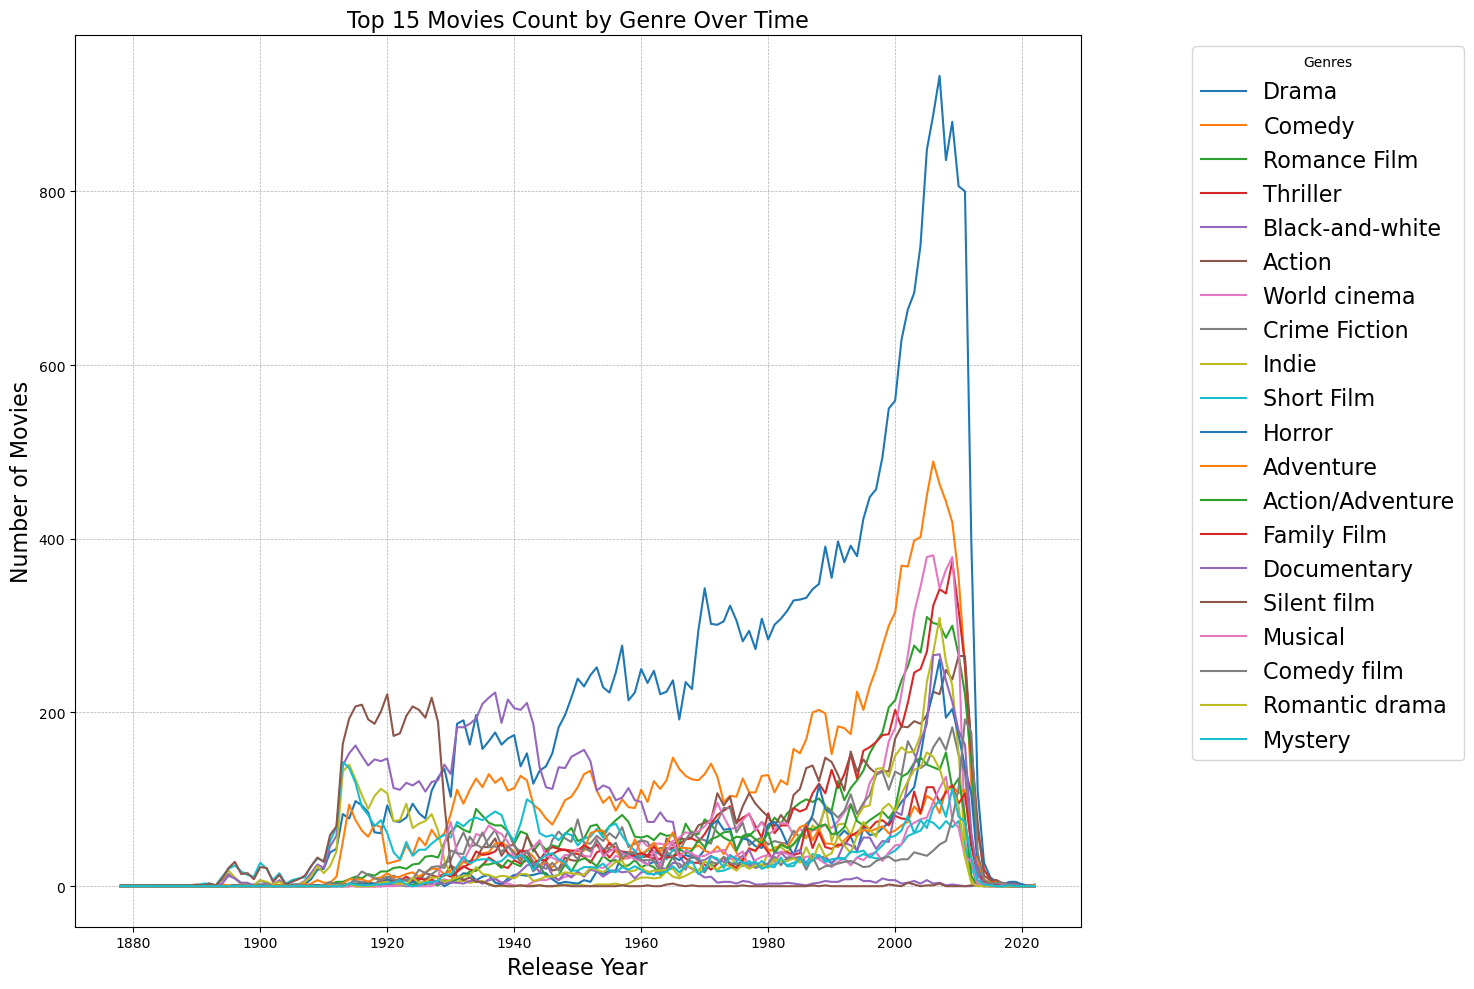

In [103]:
# Static Version of the dynamic one present in our story
# Line plot
# Keeping only the year as we are looking at year distribution
line_plot_df = movies.copy()
line_plot_df['year'] = pd.to_datetime(line_plot_df['combined_release_date']).dt.year
line_plot_df['movie_genres_final'] = line_plot_df['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
n_genre_per_year = line_plot_df.explode('movie_genres_final')
# Keep only the top 20 genres
genre_counts = n_genre_per_year['movie_genres_final'].value_counts()
best_genres = genre_counts.head(20).index.tolist()
n_genre_per_year = n_genre_per_year[n_genre_per_year['movie_genres_final'].isin(best_genres)]
# Ensure the order of the genres
n_genre_per_year['movie_genres_final'] = pd.Categorical(n_genre_per_year['movie_genres_final'], categories=best_genres, ordered=True)
# Count the number of movies per genre per year
n_genre_per_year = n_genre_per_year.groupby(['year', 'movie_genres_final']).size().reset_index(name='movie_count')
# Defining the Line Plot
plt.figure(figsize=(15, 10))
for genre in best_genres:
    genre_data = n_genre_per_year[n_genre_per_year['movie_genres_final'] == genre]
    plt.plot(genre_data['year'], genre_data['movie_count'], label=genre)
plt.title('Top 15 Movies Count by Genre Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16)
plt.legend(title='Genres', bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./plots/lineplot.png', dpi=300, bbox_inches='tight')
plt.show()


Here, we can see that most genres have movies spanning from 1900 to the present, with a higher concentration of more recent movies.

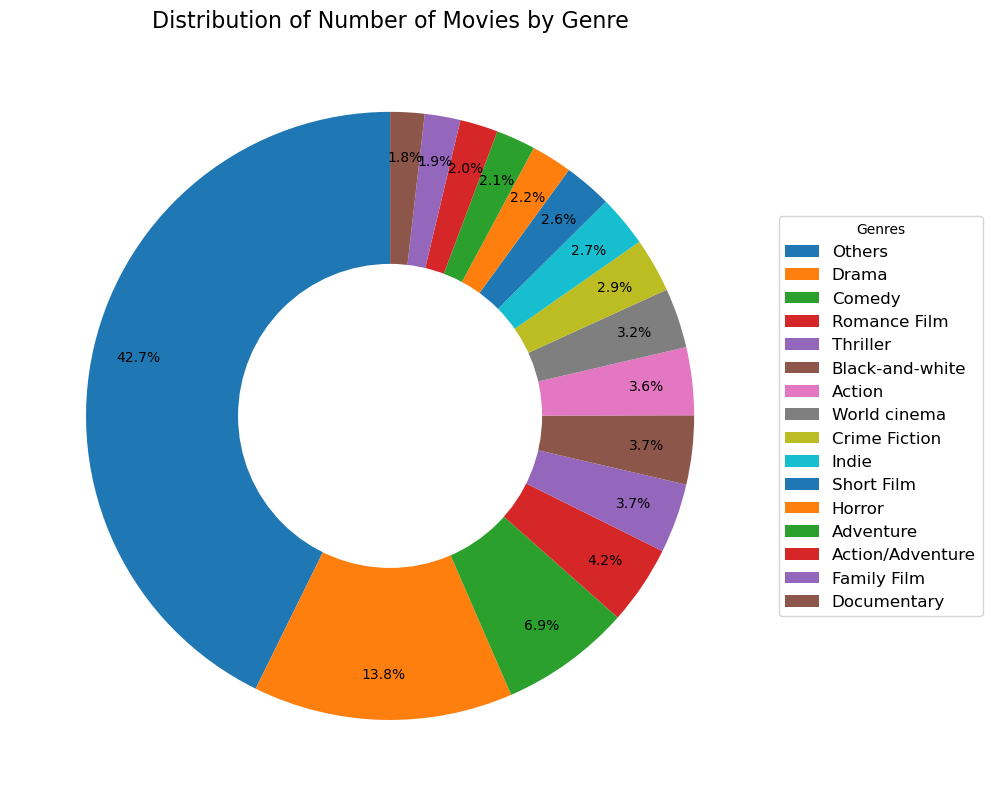

In [104]:
# Donut chart
# Movies have more than one genre, so we need to explode the genres to count them
movies_pie_df = movies.copy()
movies_pie_df['movie_genres_final'] = movies_pie_df['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
genre_per_film = movies_pie_df.explode('movie_genres_final')
# Put the genres that are not in the top 15 represented in our dataframe in the "Others" category
n_genres = genre_per_film['movie_genres_final'].value_counts()
top_20_genres = n_genres.head(20).index.tolist()
top_15_genres = n_genres.head(15).index.tolist()
genre_per_film['movie_genres_final'] = genre_per_film['movie_genres_final'].apply(lambda x: x if x in top_15_genres else 'Others')
# Recalculate the number of movies per genre with the new "Others" category
n_genres = genre_per_film['movie_genres_final'].value_counts().reset_index()
n_genres.columns = ['Genre', 'Count']
# Create a donut chart
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(
    n_genres['Count'],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    textprops={'fontsize': 10},
)
# Making it a donut
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig.gca().add_artist(centre_circle)
ax.legend(
    wedges,
    n_genres['Genre'],
    title='Genres',
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12,
)
ax.set_title('Distribution of Number of Movies by Genre', fontsize=16)
plt.tight_layout()
plt.savefig('./plots/donutplot.png', dpi=300, bbox_inches='tight')
plt.show()

Here we can see that the most popular genres are indeed the most represented in our dataset.

To extend our analysis, we computed the number of successful movies per year and visualized it using a hexbin heatmap plot. This allows us to observe trends in movie success over time and identify periods with higher concentrations of successful films.

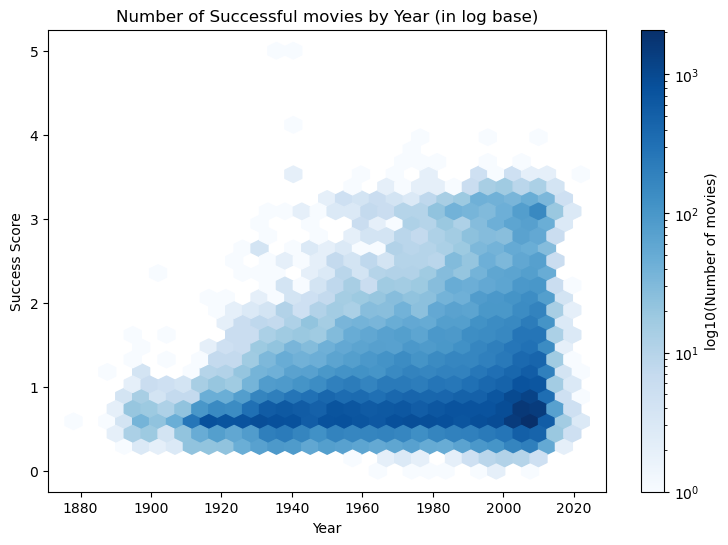

In [105]:
# Hexbin plot
# Create a copy to not modify our final dataframe
# Keeping only the year as we are looking at year distribution
success_by_year = movies.copy()
success_by_year['year'] = pd.to_datetime(success_by_year['combined_release_date']).dt.year
plt.figure(figsize=(9, 6))
plt.hexbin(success_by_year['year'], success_by_year['success_metric_scaled'],gridsize=30,cmap='Blues',bins='log')
plt.colorbar(label='log10(Number of movies)')

plt.xlabel('Year')
plt.ylabel('Success Score')
plt.title('Number of Successful movies by Year (in log base)')
plt.savefig('./plots/hexbinplot.png', dpi=300, bbox_inches='tight')
plt.show()

We can distinguish a noticeable improvement in movie success over time. This trend aligns with advancements in the film industry, increased production budgets and global distribution.

But a year isn't sufficient to define the golden age of a genre. Let's work with decades

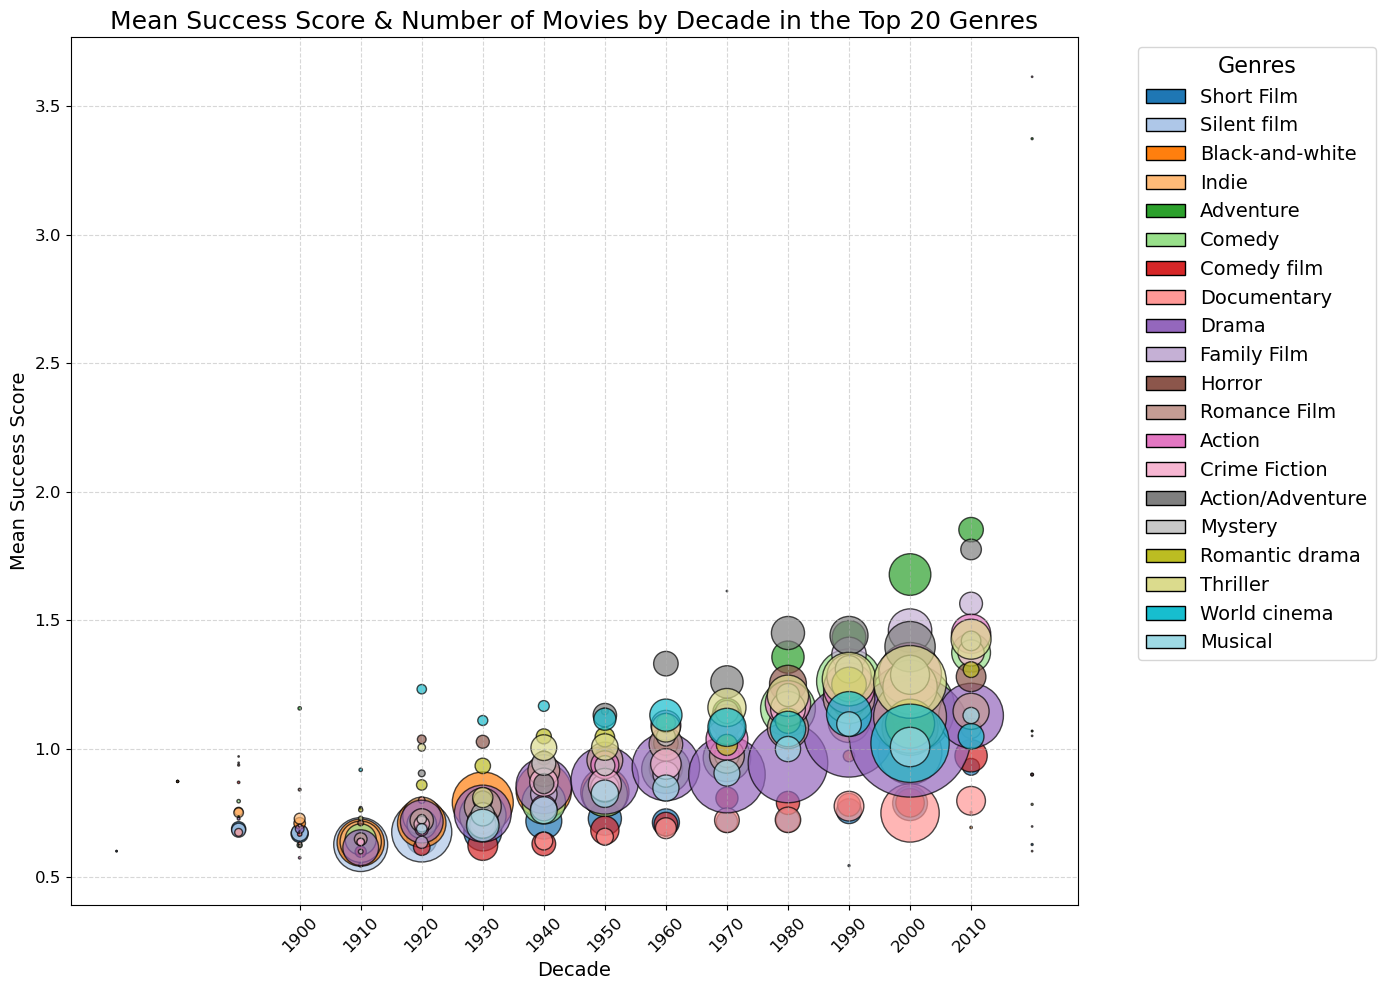

In [109]:
# Movies have more than one genre, so we need to explode the genres to count them
df_bubble = movies.copy()
df_bubble['movie_genres_final'] = df_bubble['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
# We only need the year and not decade
df_bubble['release_year'] = pd.to_datetime(df_bubble['combined_release_date']).dt.year
df_bubble['decade'] = df_bubble['release_year'].apply(get_decade)
all_genres_per_film = df_bubble.explode('movie_genres_final')
# Keep 20 most populare genre in our dataset for readability of our plot
top_20_genres = all_genres_per_film['movie_genres_final'].value_counts().head(20).index
popular_movies_genre = all_genres_per_film[all_genres_per_film['movie_genres_final'].isin(top_20_genres)]
# Compute the mean success score and the number of released movie by decade and genre
grouped = popular_movies_genre.groupby(['decade', 'movie_genres_final']).agg(
    count=('movie_genres_final', 'size'),
    mean_success_score=('success_metric_scaled', 'mean')
).reset_index()

# Define distinct colors for genres
unique_genres = grouped['movie_genres_final'].unique()
color_map = {genre: color for genre, color in zip(unique_genres, plt.cm.tab20.colors)}

# Static bubble chart
plt.figure(figsize=(14, 10))

# Plot each genre separately for individual colors
for genre in unique_genres:
    genre_data = grouped[grouped['movie_genres_final'] == genre]
    plt.scatter(
        genre_data['decade'],  # X-axis: Decade
        genre_data['mean_success_score'],  # Y-axis: Mean success score
        s=genre_data['count'],  # Scale bubble size
        color=color_map[genre],
        alpha=0.7,  # Transparency for overlapping bubbles
        edgecolors="black",
    )

# Add chart elements
plt.title('Mean Success Score & Number of Movies by Decade in the Top 20 Genres', fontsize=18)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Mean Success Score', fontsize=14)
plt.xticks(range(1900, 2020, 10), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Create a legend with only colors (no bubbles)
legend_elements = [
    Patch(facecolor=color_map[genre], edgecolor='black', label=genre) for genre in unique_genres
]
plt.legend(
    handles=legend_elements,
    title="Genres",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16,
)

# Save and display the plot
plt.tight_layout()
plt.savefig('./plots/bubble.png', dpi=300, bbox_inches='tight')
plt.show()


Let's compute the golden age as the decade with the highest mean success score for each genre.

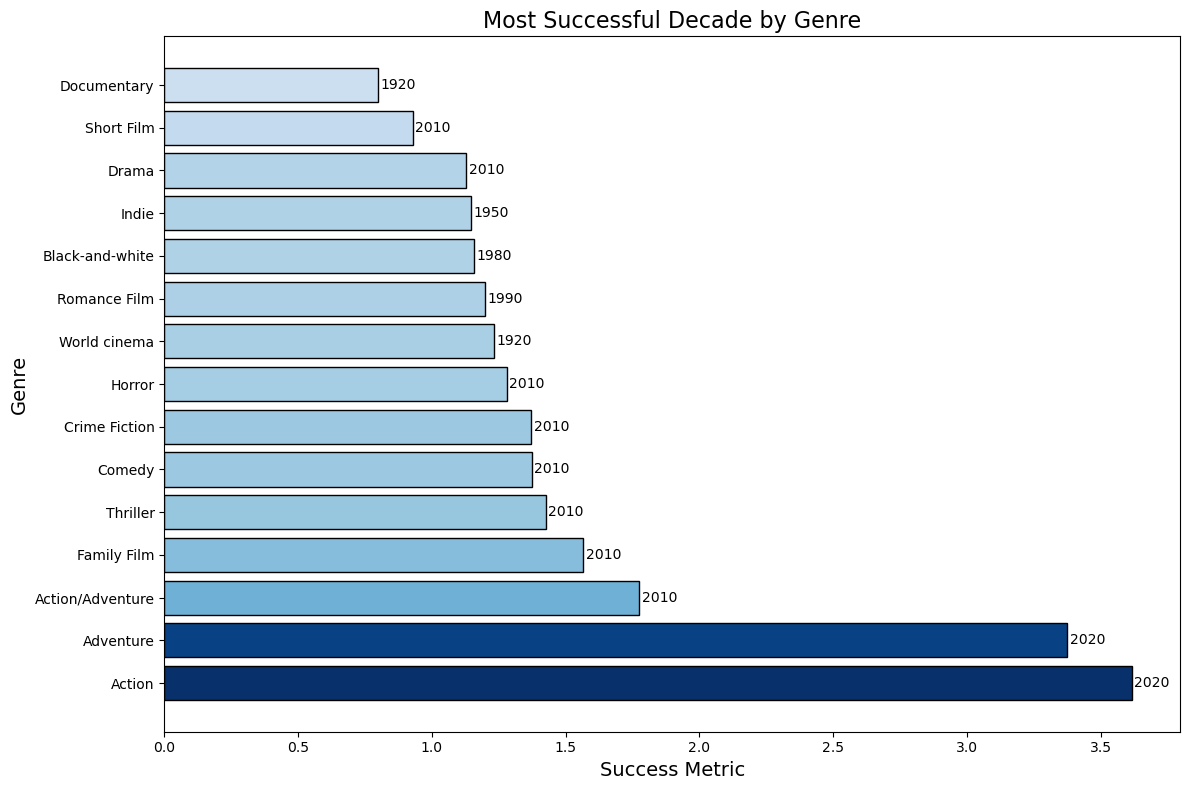

In [116]:
# Movies have more than one genre, so we need to explode the genres to count them
golden_age_df = movies.copy()
golden_age_df['movie_genres_final'] = golden_age_df['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
# Assign to each movie its decade
golden_age_df['release_year'] = pd.to_datetime(golden_age_df['combined_release_date']).dt.year
golden_age_df['decade'] = (golden_age_df['release_year'] // 10) * 10
all_genres_per_film = golden_age_df.explode('movie_genres_final')
#Working with the top 15 genres
top_15_genres = all_genres_per_film['movie_genres_final'].value_counts().head(15).index
popular_movies_genre = all_genres_per_film[all_genres_per_film['movie_genres_final'].isin(top_15_genres)]
# Compute the mean by decade by genre and takinf the max
genre_decade_success = popular_movies_genre.groupby(['movie_genres_final', 'decade'])['success_metric_scaled'].mean().reset_index()
golden_age = genre_decade_success.loc[genre_decade_success.groupby('movie_genres_final')['success_metric_scaled'].idxmax()]
golden_age = golden_age.rename(columns={'decade': 'Golden Age/ Most Successful Decade', 'success_metric_scaled': 'Max Success Metric'})
golden_age_sorted = golden_age.sort_values(by='Max Success Metric', ascending=False)
plt.figure(figsize=(12, 8))
# Horizontal Bar Plot
bars = plt.barh(
    golden_age_sorted['movie_genres_final'],  # Genres on the y-axis
    golden_age_sorted['Max Success Metric'],  # Success Metric on the x-axis
    color=plt.cm.Blues(golden_age_sorted['Max Success Metric'] / golden_age_sorted['Max Success Metric'].max()),
    edgecolor='black',
)
for bar,decade in zip(bars,golden_age_sorted['Golden Age/ Most Successful Decade']):
    plt.text(
        bar.get_width()+0.01,
        bar.get_y()+bar.get_height()/2,
        str(decade),
        va='center', fontsize=10
    )
plt.title('Most Successful Decade by Genre', fontsize=16)
plt.xlabel('Success Metric', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.tight_layout()
plt.savefig('./plots/golden_age.png', dpi=300, bbox_inches='tight')
plt.show()

Here we can see some patterns. First of all, the Action and adventure had a big 2020 decade start for the Action and Adventure genre. We see also that some genres have very old "golden age" like "Black and White" and "Documnetary".

Finally, Let's now analyze the success score by country:

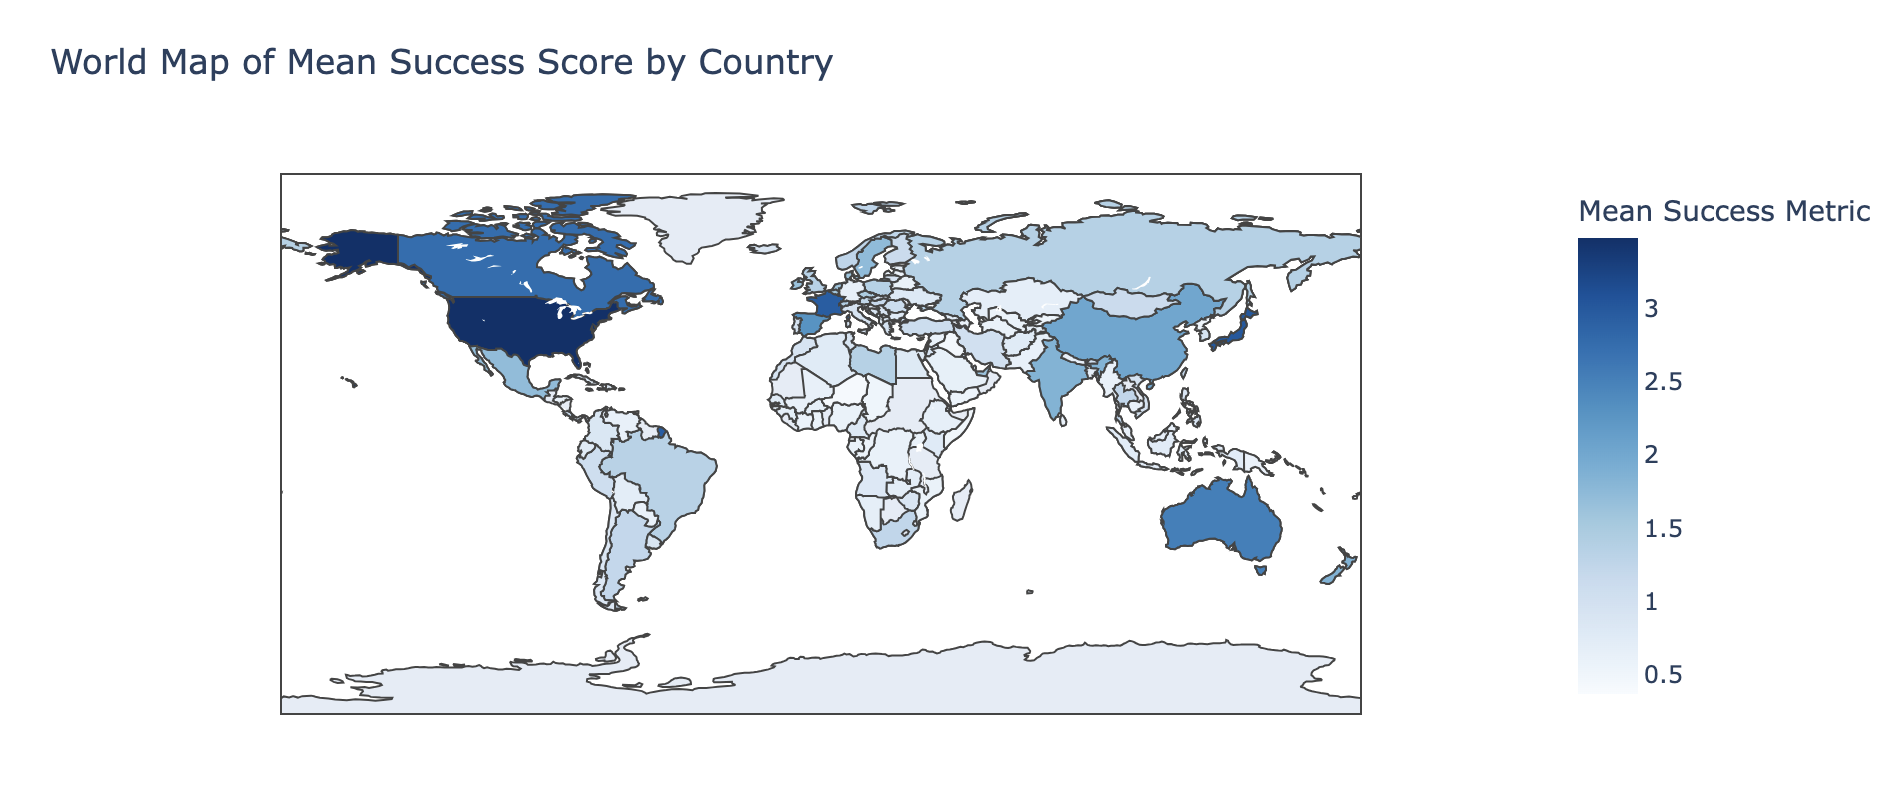

In [107]:
# As it is very difficult to do a static world map plot, we display an image
display(Image(filename='./plots/WorldMap.png'))

It is not surprising to see the United States of America at the top, as they are known for producing cinematic masterpieces. Furthermore, we observe that Canada, France, Japan, Spain, China, and India are not far behind.

# Impact timeseries

Now that we have created our success metric. We can start implementing our impact timeseries. They represent the impact a movie genre has on the movie industry. The motivations behind the creation of these timeseries as well as the methods implemented to create them are explained in more details in the `methods.ipynb` notebook.

In [2]:
# We read the saved data. Allows to start running the notebook from here
success_df = pd.read_pickle('./data/Success_Metric.pkl')
success_df.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,0.143767,0.996126,United States of America,"[Film adaptation, Costume drama, Roadshow thea...",0.619947,1.0,0.785789,22.186218,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,0.149518,1.000000,United States of America,"[Romance Film, Musical, Fantasy, Family Film, ...",0.619947,1.0,0.696421,21.949103,4.944015
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,0.096125,0.567962,United States of America,"[Adventure, Children's/Family, Animation, Comi...",0.619947,1.0,0.684211,18.456170,4.119294
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,0.278692,0.442916,United States of America,"[Science Fiction, Adventure, Fantasy, Coming o...",0.619947,1.0,0.810947,17.836009,3.972866
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,0.785462,0.471324,United States of America,"[Tragedy, Costume drama, Historical fiction, A...",0.592075,1.0,0.714080,17.689057,3.938169


We only keep the columns of the dataframe that are of interest to us.

In [3]:
success_df = success_df[["combined_release_date", "movie_genres_final", "success_score"]]
success_df = success_df.explode('movie_genres_final')
success_df.head()

,combined_release_date,movie_genres_final,success_score
30973,1939-12-15,Film adaptation,22.186218
30973,1939-12-15,Costume drama,22.186218
30973,1939-12-15,Roadshow theatrical release,22.186218
30973,1939-12-15,Epic,22.186218
30973,1939-12-15,Period piece,22.186218


We are going to limit our impact analysis to the genres that have more than 3000 movies. 

In [4]:
genre_counts = success_df['movie_genres_final'].value_counts()
genres_to_keep = genre_counts[genre_counts > 3000].index
success_filtered_df = success_df[success_df['movie_genres_final'].isin(genres_to_keep)]
success_filtered_df.head()

,combined_release_date,movie_genres_final,success_score
30973,1939-12-15,Drama,22.186218
30973,1939-12-15,Romantic drama,22.186218
30973,1939-12-15,Romance Film,22.186218
9888,1937-12-21,Romance Film,21.949103
9888,1937-12-21,Musical,21.949103


We can start generating our impact timeseries. For this, we call the `impact_genre` function which takes as input a dataframe with all the movies in a given genre.  

Here are the total number of movies for each genre:
Genre: Drama, Number of Movies: 30088
Genre: Comedy, Number of Movies: 15138
Genre: Romance Film, Number of Movies: 9156
Genre: Thriller, Number of Movies: 8073
Genre: Black-and-white, Number of Movies: 7977
Genre: Action, Number of Movies: 7848
Genre: World cinema, Number of Movies: 6929
Genre: Crime Fiction, Number of Movies: 6298
Genre: Indie, Number of Movies: 5959
Genre: Short Film, Number of Movies: 5568
Genre: Horror, Number of Movies: 4731
Genre: Adventure, Number of Movies: 4563
Genre: Action/Adventure, Number of Movies: 4413
Genre: Family Film, Number of Movies: 4135
Genre: Documentary, Number of Movies: 3964
Genre: Silent film, Number of Movies: 3725
Genre: Musical, Number of Movies: 3652
Genre: Comedy film, Number of Movies: 3438
Genre: Romantic drama, Number of Movies: 3240


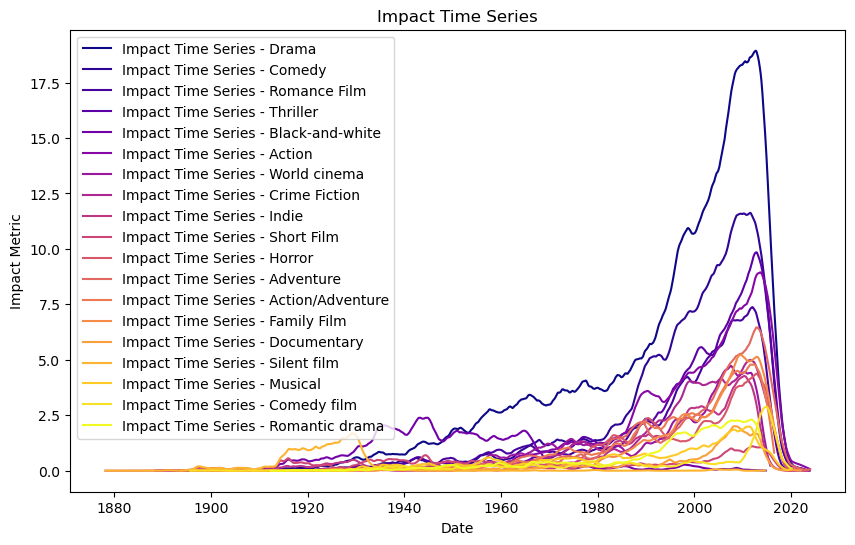

In [5]:
success_df_by_genre = {}
impact_timeseries_by_genre = {}

cmap = cm.get_cmap("plasma", len(genres_to_keep))
genre_colors = {genre: cmap(i) for i, genre in enumerate(genres_to_keep)}

for genre in genres_to_keep:
    success_df_by_genre[genre] = success_filtered_df[success_filtered_df['movie_genres_final'] == genre]

print("Here are the total number of movies for each genre:")

plt.figure(figsize=(10, 6))
for genre, genre_df in success_df_by_genre.items():
    print(f"Genre: {genre}, Number of Movies: {len(genre_df)}")
    impact_timeseries_by_genre[genre] = impact_genre(genre_df)

    plt.plot(impact_timeseries_by_genre[genre], label=f"Impact Time Series - {genre}", color=genre_colors[genre])
    plt.title("Impact Time Series")
    plt.xlabel("Date")
    plt.ylabel("Impact Metric")
    plt.legend()

plt.show()

We can see that we get some nice timeseries. The bad results at the end come from lack of movie data. We can now make some more detailed analysis on these and also start working on the prediction. But we first start by saving the processed data into a `.pkl` file so that we don't have to re-run this process everytime.

In [6]:
output_dir = "./data/Impact_Timeseries/"
os.makedirs(output_dir, exist_ok=True)

for genre, timeseries in impact_timeseries_by_genre.items():
    genre = genre.replace(" ", "_").replace("/", "2")
    save_path = os.path.join(output_dir, f"{genre}.csv")
    print(f"Saving to: {save_path}")
    timeseries.to_csv(save_path)

Saving to: ./data/Impact_Timeseries/Drama.csv
Saving to: ./data/Impact_Timeseries/Comedy.csv
Saving to: ./data/Impact_Timeseries/Romance_Film.csv
Saving to: ./data/Impact_Timeseries/Thriller.csv
Saving to: ./data/Impact_Timeseries/Black-and-white.csv
Saving to: ./data/Impact_Timeseries/Action.csv
Saving to: ./data/Impact_Timeseries/World_cinema.csv
Saving to: ./data/Impact_Timeseries/Crime_Fiction.csv
Saving to: ./data/Impact_Timeseries/Indie.csv
Saving to: ./data/Impact_Timeseries/Short_Film.csv
Saving to: ./data/Impact_Timeseries/Horror.csv
Saving to: ./data/Impact_Timeseries/Adventure.csv
Saving to: ./data/Impact_Timeseries/Action2Adventure.csv
Saving to: ./data/Impact_Timeseries/Family_Film.csv
Saving to: ./data/Impact_Timeseries/Documentary.csv
Saving to: ./data/Impact_Timeseries/Silent_film.csv
Saving to: ./data/Impact_Timeseries/Musical.csv
Saving to: ./data/Impact_Timeseries/Comedy_film.csv
Saving to: ./data/Impact_Timeseries/Romantic_drama.csv


Here are some plots that could be used for the website.

<Figure size 800x600 with 0 Axes>

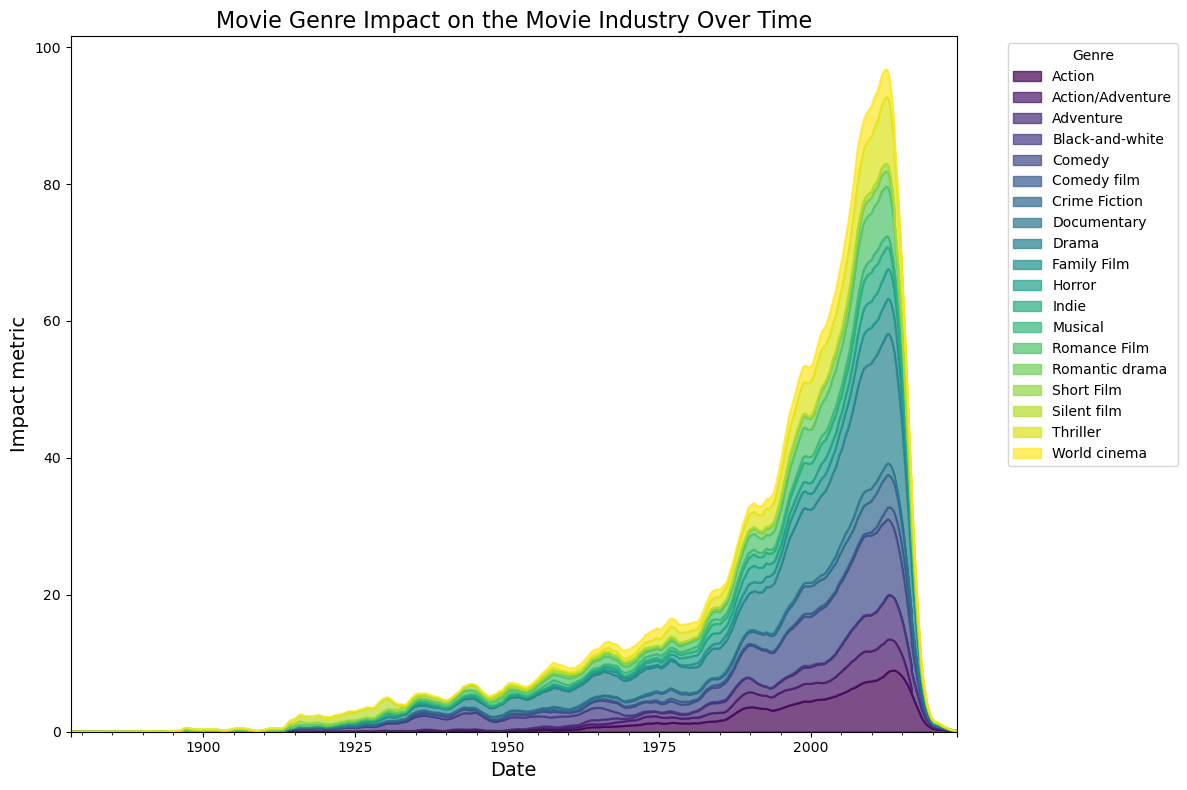

In [2]:
impact_data_dir = "./data/Impact_Timeseries/"
impact_array = []

for file_name in os.listdir(impact_data_dir):
    if file_name.endswith(".csv"): 
        genre_name = file_name.replace(".csv", "").replace("_", " ").replace("2", "/")
        file_path = os.path.join(impact_data_dir, file_name)
        df = pd.read_csv(file_path, names=["Date", "Impact"], header=0, parse_dates=['Date'])
        df = df.drop(index=0)
        df['Genre'] = genre_name  
        impact_array.append(df)

combined_impact_df = pd.concat(impact_array, ignore_index=True)

formatted_impact_df = combined_impact_df.pivot_table(index='Date', columns='Genre', values='Impact', aggfunc='sum')
formatted_impact_df = formatted_impact_df.fillna(0) 

plt.figure(figsize=(8, 6))
formatted_impact_df.plot(kind='area', stacked=True, figsize=(12, 8), alpha=0.7, cmap='viridis') 
plt.title("Movie Genre Impact on the Movie Industry Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Impact metric", fontsize=14)
plt.legend(title="Genre", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

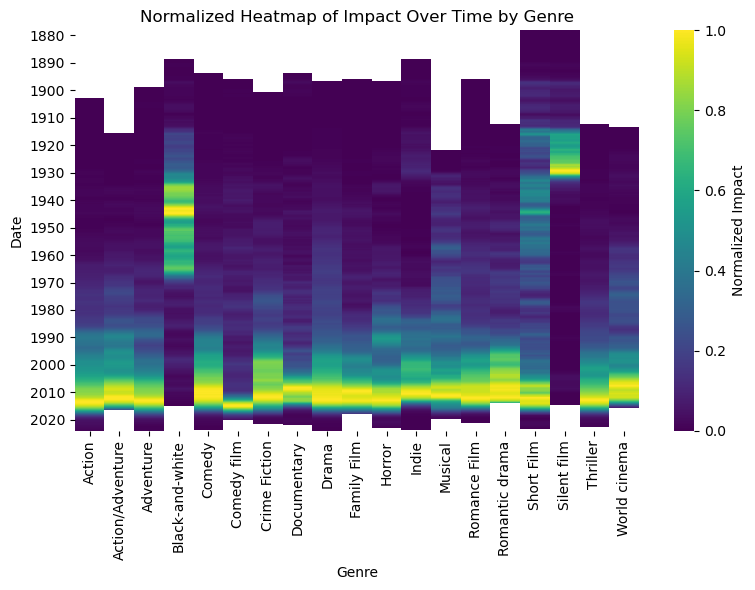

In [3]:
normalized_impact_by_genre_df = combined_impact_df.copy()
normalized_impact_by_genre_df['Impact'] = normalized_impact_by_genre_df.groupby('Genre')['Impact'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

norm_impact_pivot_df = normalized_impact_by_genre_df.pivot(index='Date', columns='Genre', values='Impact')

norm_impact_pivot_df['Decade'] = (norm_impact_pivot_df.index.year // 10) * 10 
decade_ticks = norm_impact_pivot_df['Decade'].drop_duplicates().values 
decade_ticks = decade_ticks[decade_ticks != 1870]
decade_indices = [norm_impact_pivot_df.index.get_loc(norm_impact_pivot_df[norm_impact_pivot_df['Decade'] == decade].index[0]) for decade in decade_ticks]

plt.figure(figsize=(8, 6))
sns.heatmap(
    norm_impact_pivot_df.drop(columns='Decade'), 
    cmap='viridis',
    cbar_kws={'label': 'Normalized Impact'},
    xticklabels=True,
    yticklabels=False  
)

plt.gca().set_yticks(decade_indices)  
plt.gca().set_yticklabels(decade_ticks) 

plt.title('Normalized Heatmap of Impact Over Time by Genre')
plt.xlabel('Genre')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

# Prediction on timeseries

For the prediction part, we need to choose when to take the cutoff point. We can see from the data that altough we have some information about movies until very recently, there seems to be a large drop off around 2010. This seems to be the point where our merged dataset doesn't have all up to date movie information. We are going thus going to set our prediction data around 2010. 

In [8]:
# We load the data from the data folder
output_dir = "./data/Impact_Timeseries/"
timeseries_load_impact_by_genre = {}

for file_name in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file_name)

    if file_name.endswith(".csv"):
        genre = os.path.splitext(file_name)[0]
        genre = genre.replace("2", " / ").replace("_", " ")
        
        timeseries = pd.read_csv(file_path, index_col=0)  
        timeseries.index = pd.to_datetime(timeseries.index)
        timeseries = timeseries.asfreq('D')
        timeseries_load_impact_by_genre[genre] = timeseries


We are at genre: Action


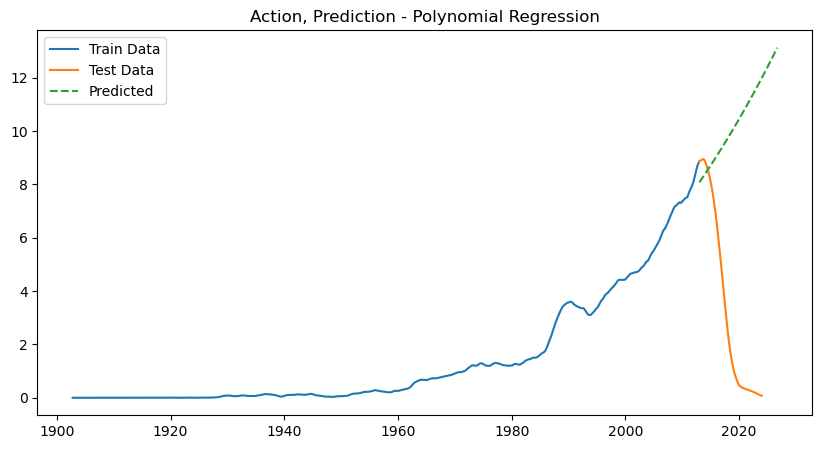

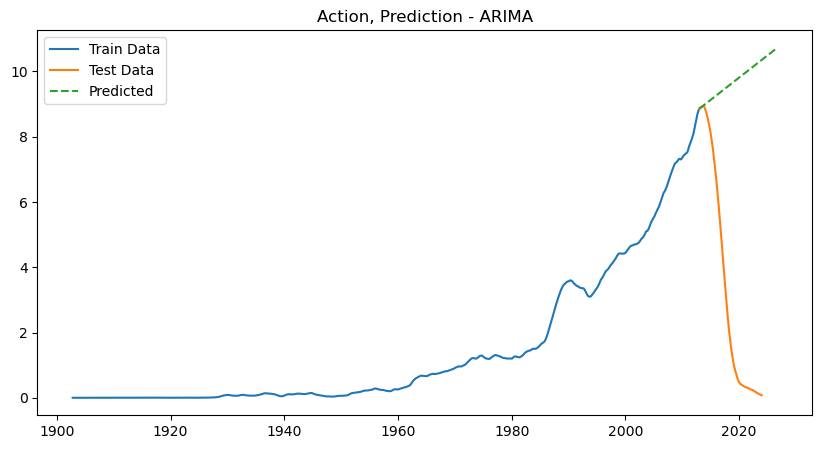

We are at genre: Action / Adventure


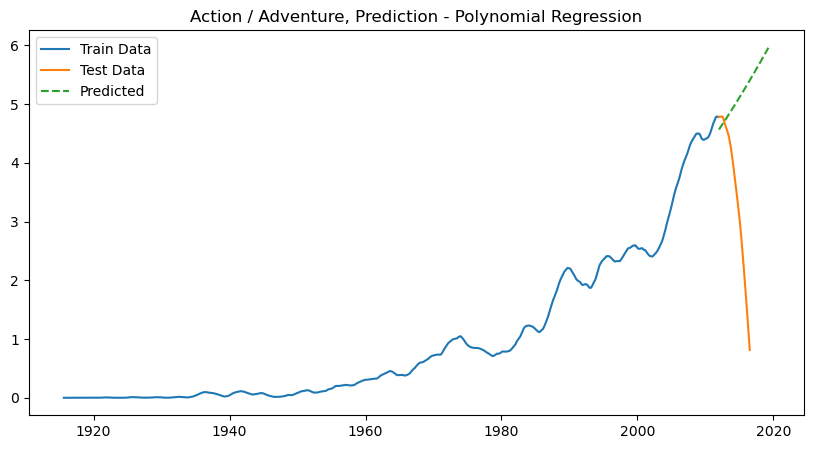

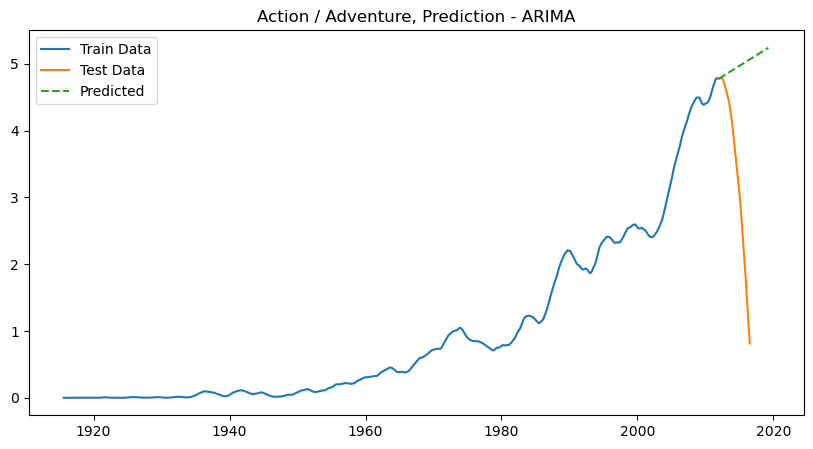

We are at genre: Adventure


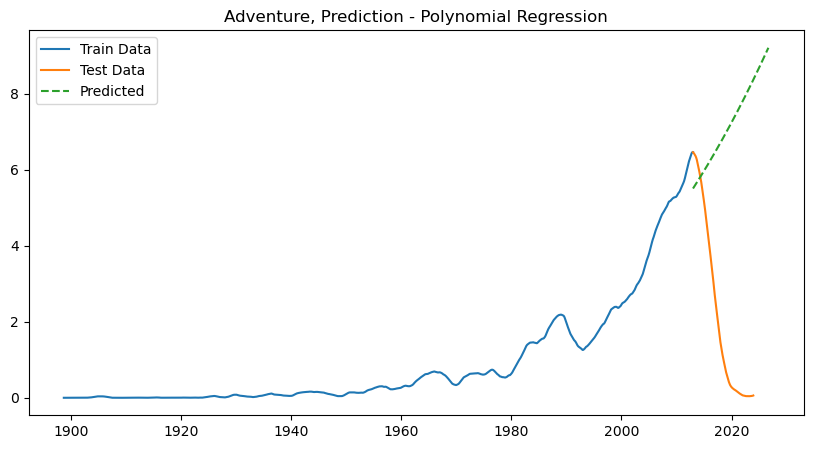

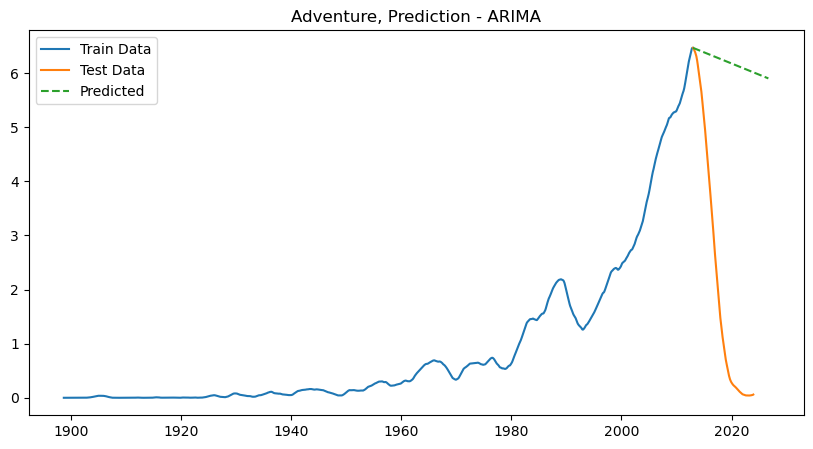

We are at genre: Black-and-white


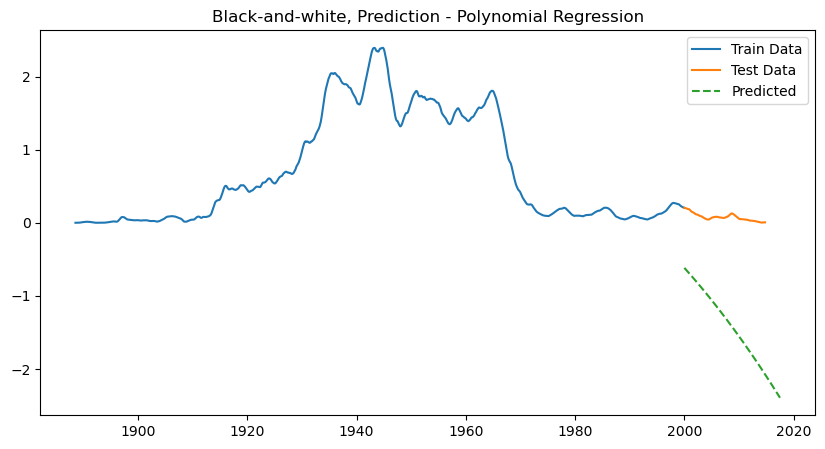

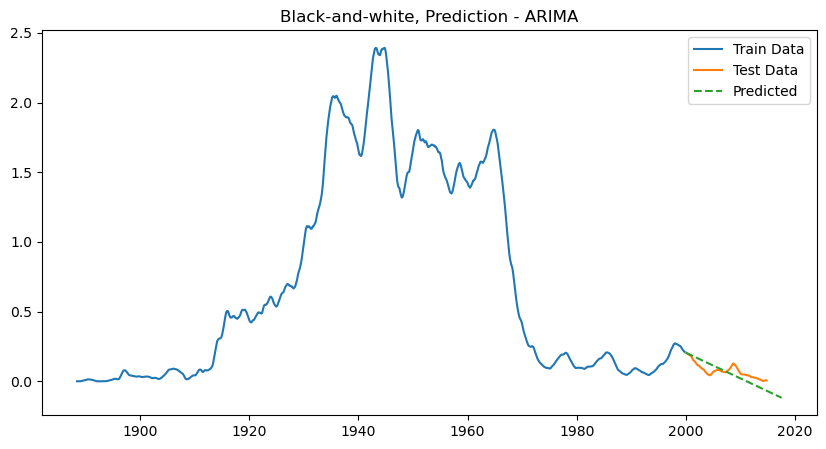

We are at genre: Comedy


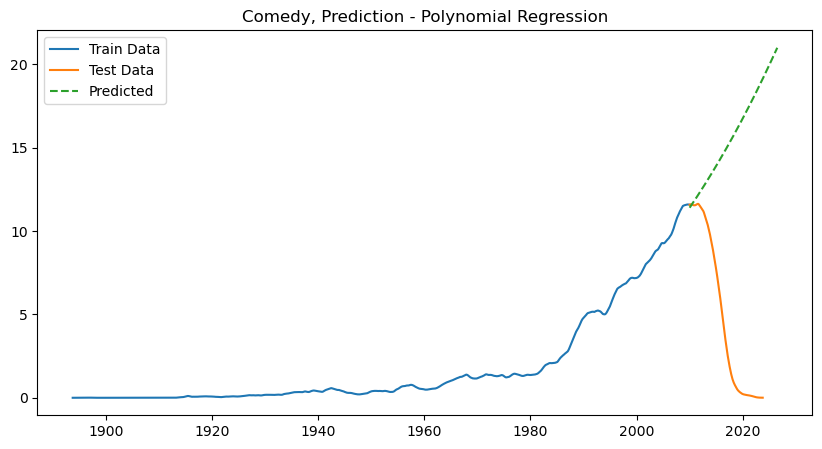

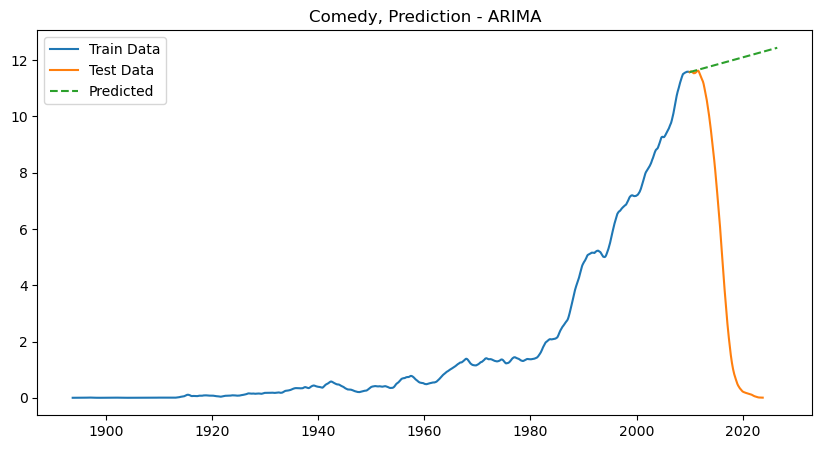

We are at genre: Comedy film


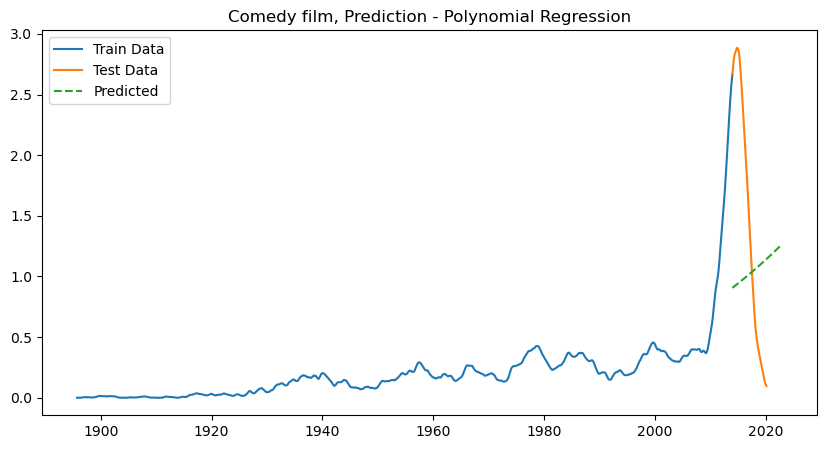

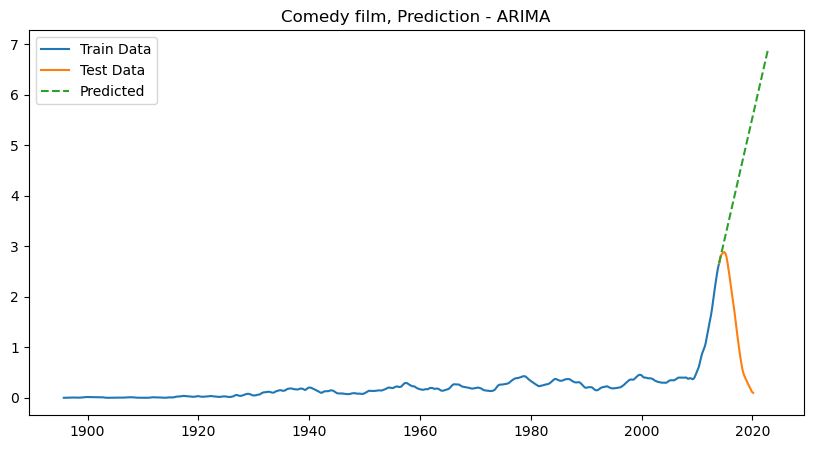

We are at genre: Crime Fiction


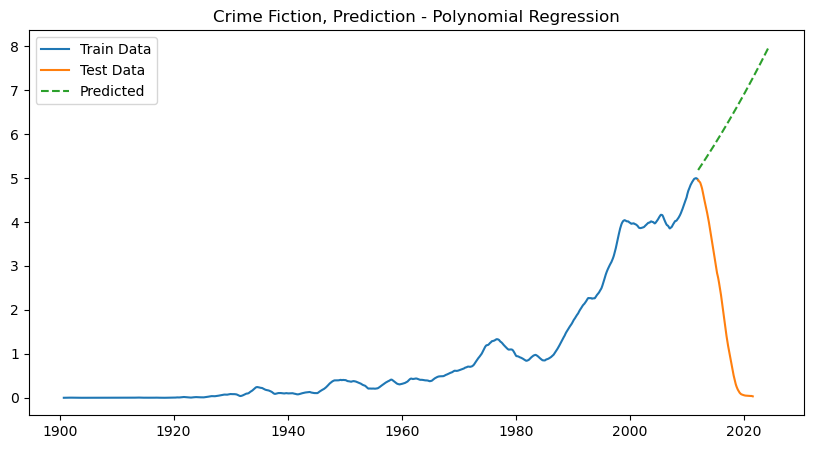

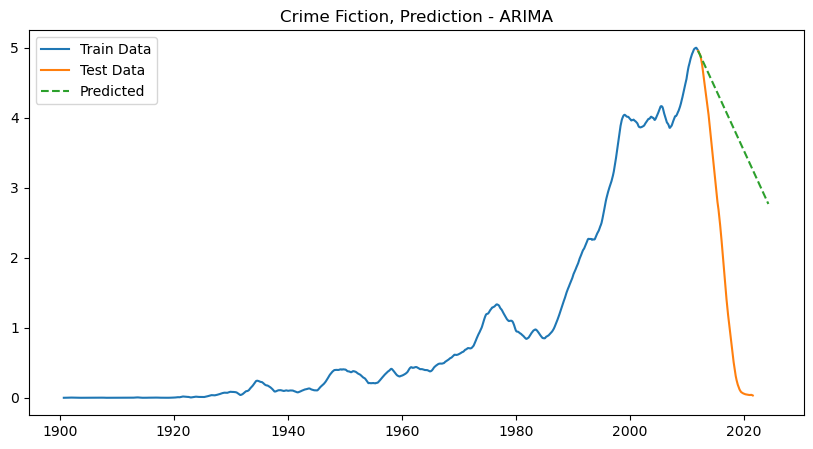

We are at genre: Documentary


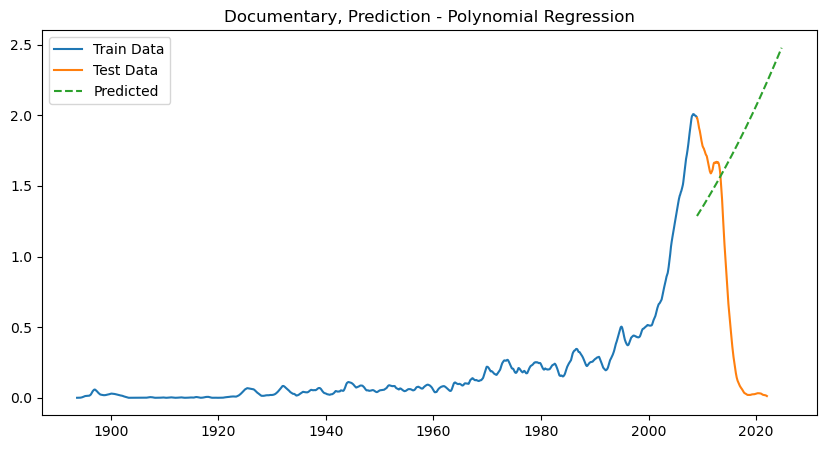

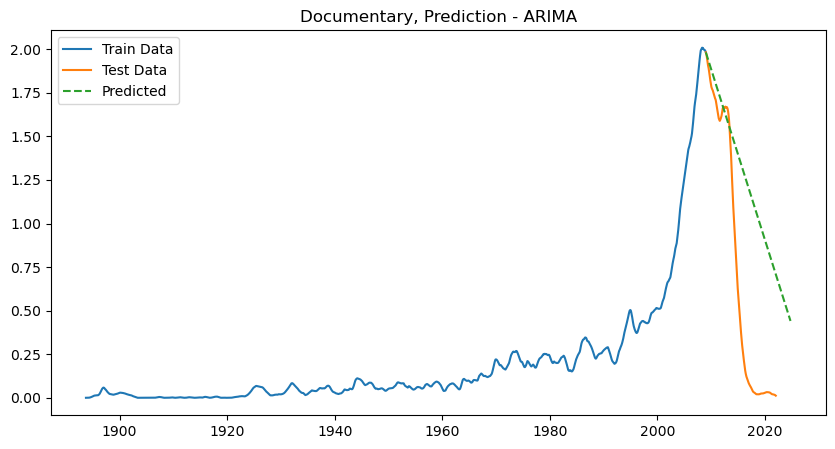

We are at genre: Drama


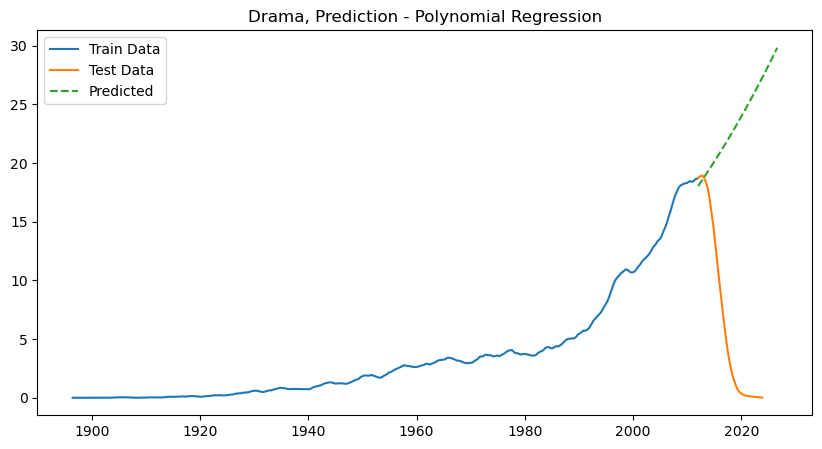

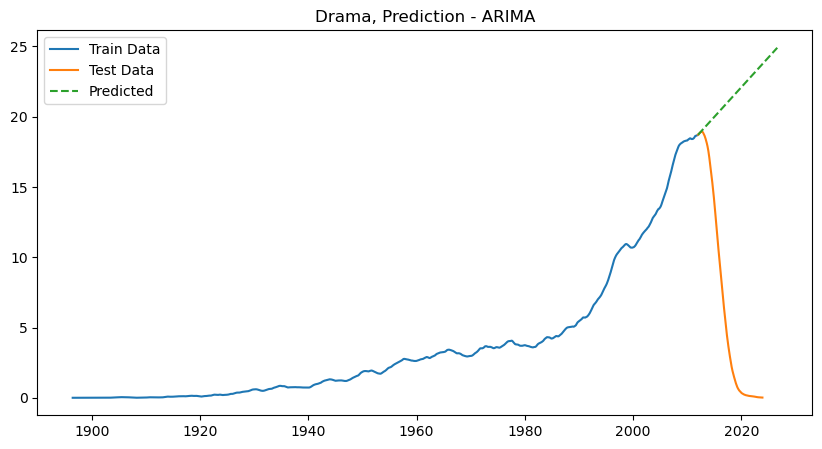

We are at genre: Family Film


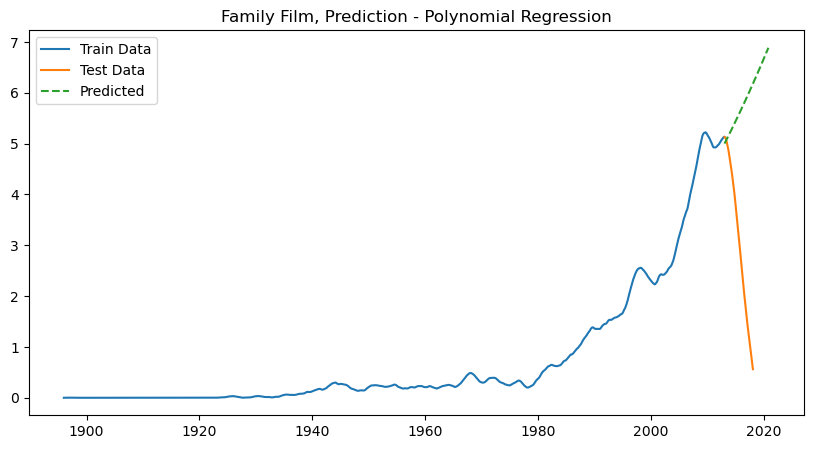

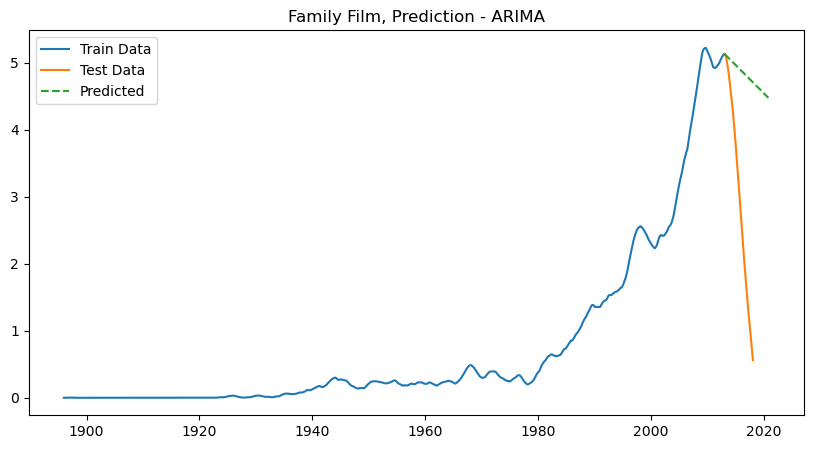

We are at genre: Horror


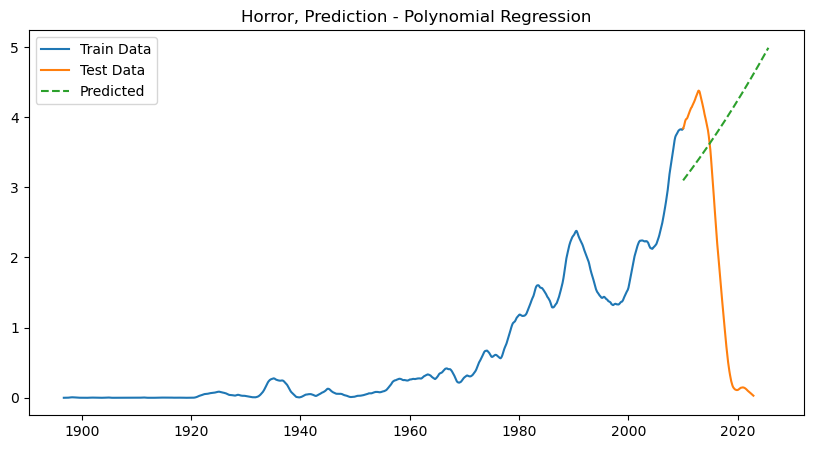

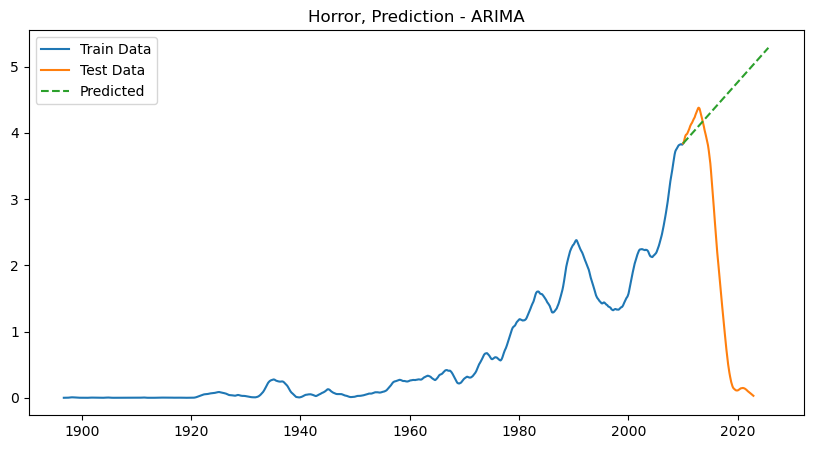

We are at genre: Indie


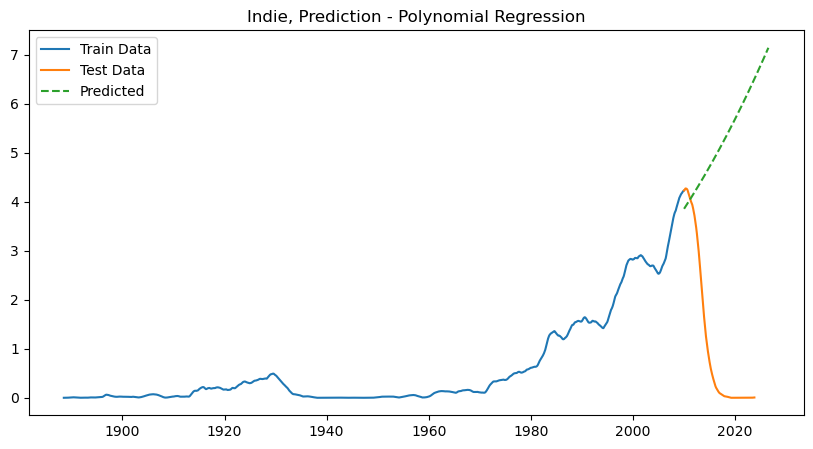

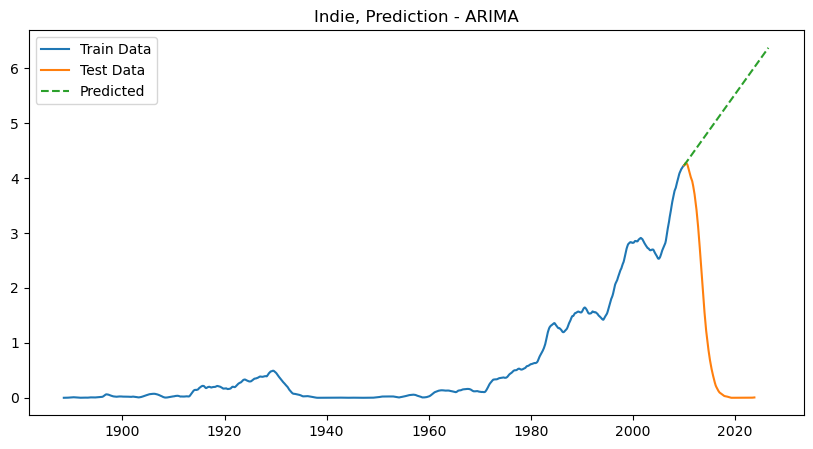

We are at genre: Musical


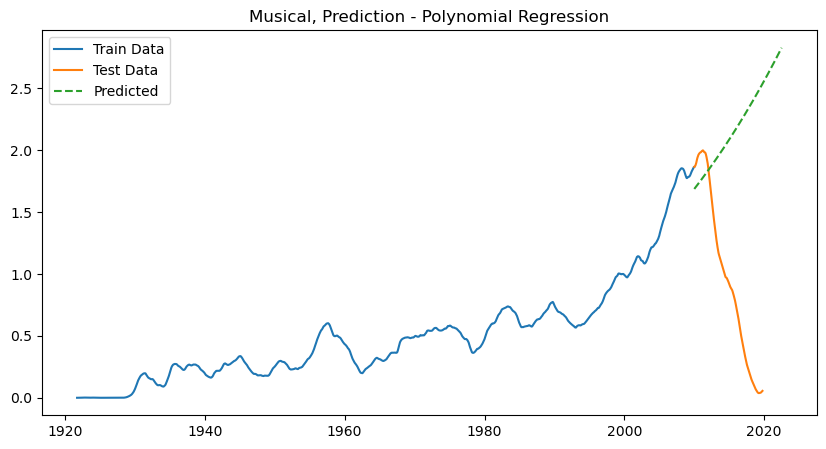

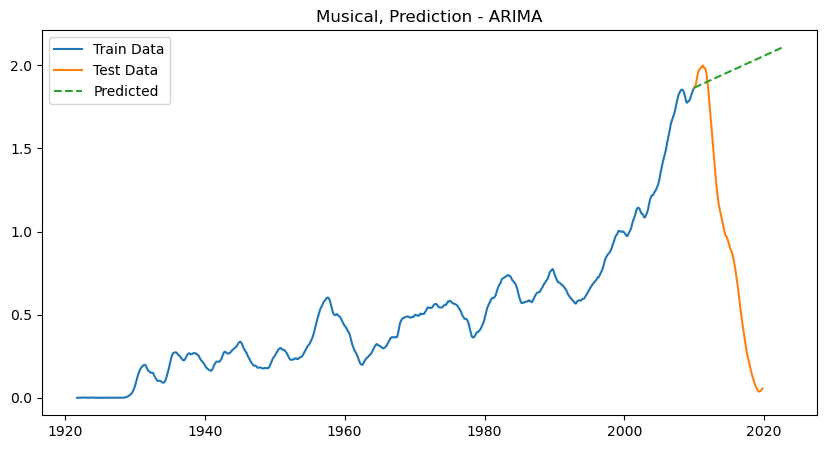

We are at genre: Romance Film


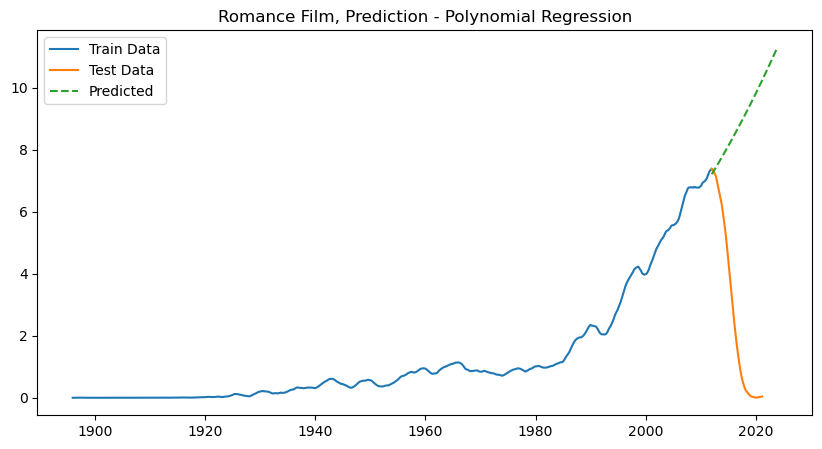

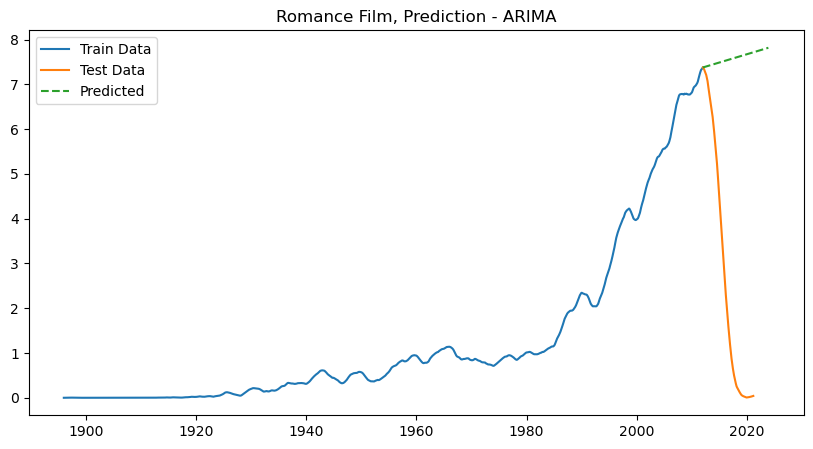

We are at genre: Romantic drama


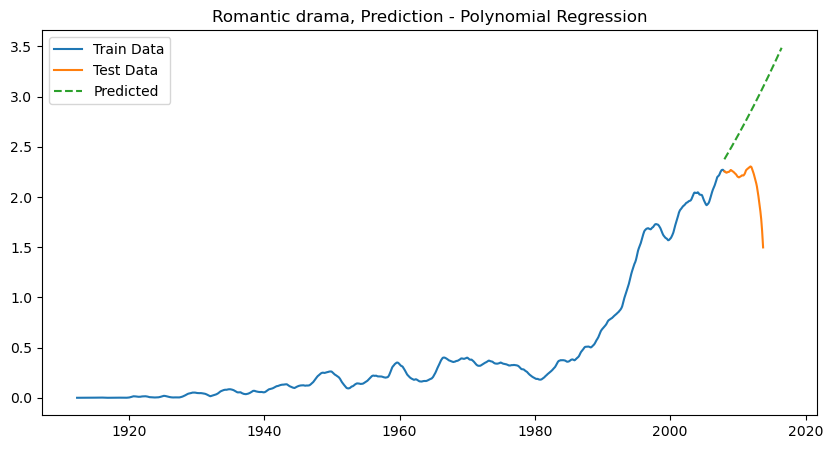

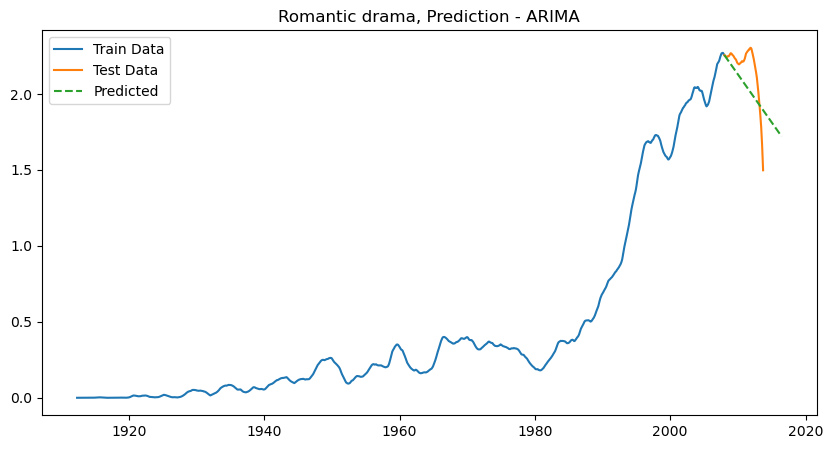

We are at genre: Short Film


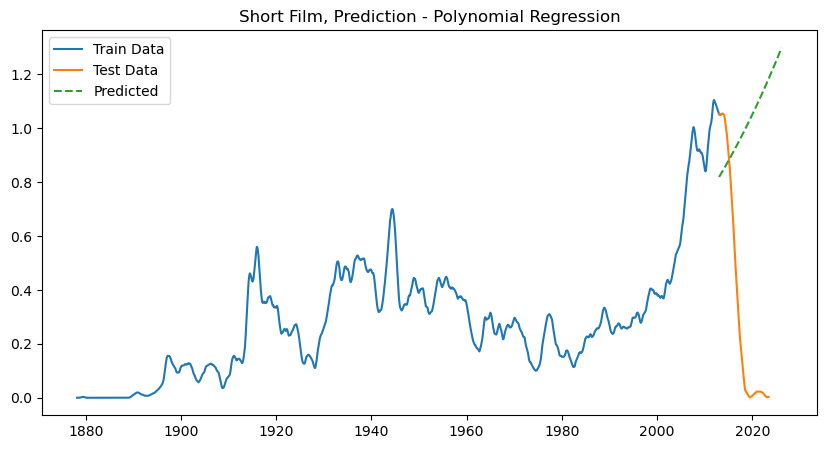

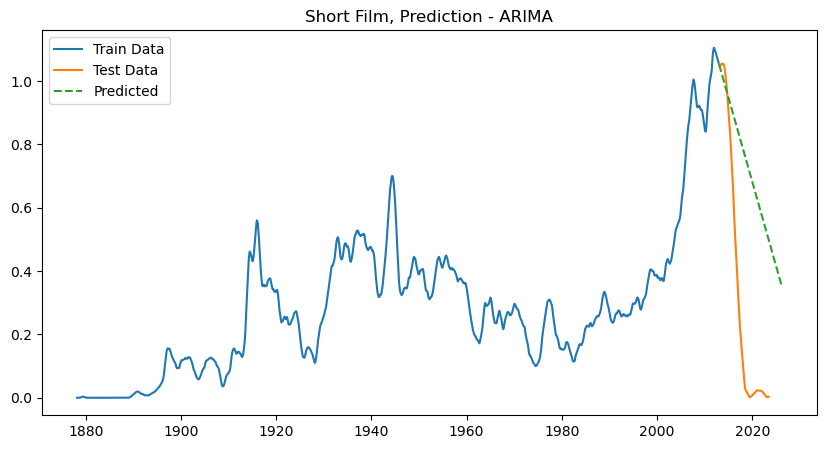

We are at genre: Silent film


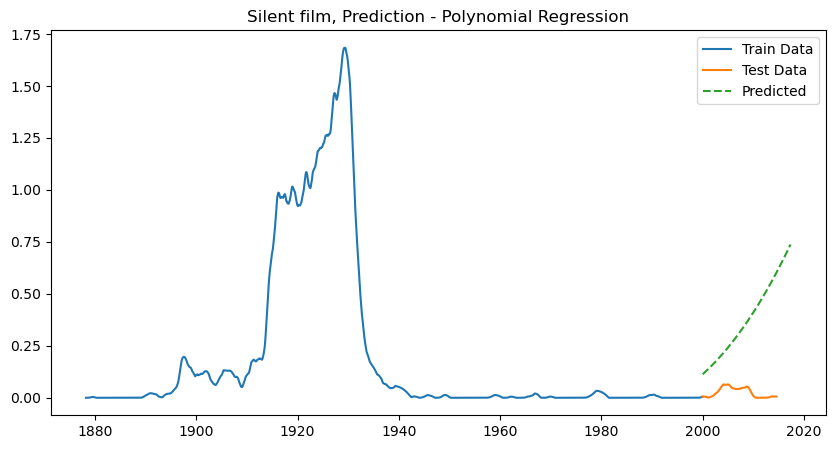

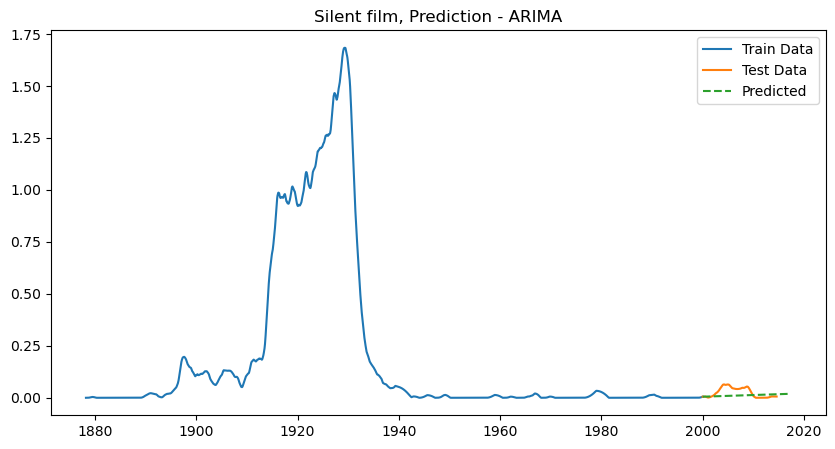

We are at genre: Thriller


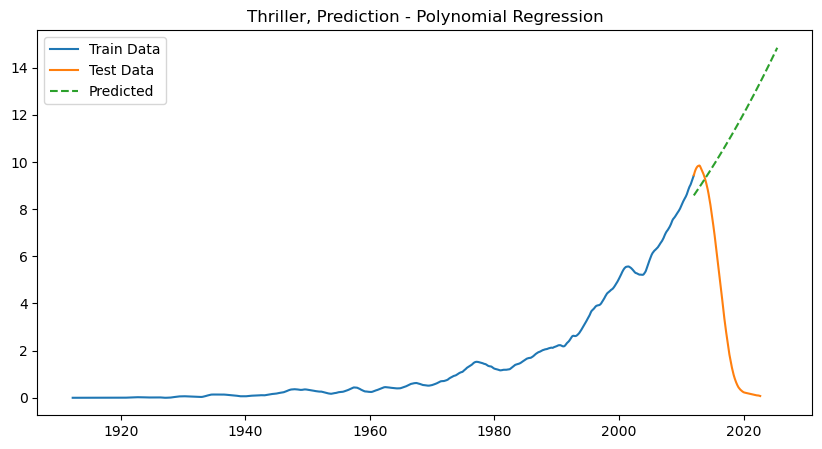

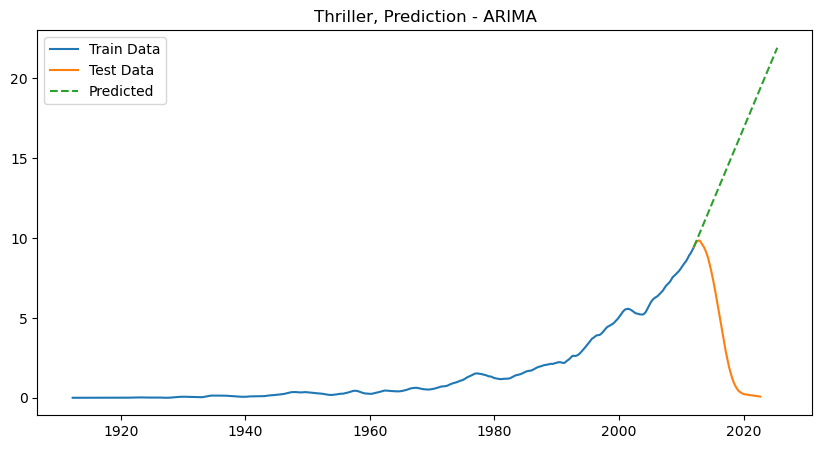

We are at genre: World cinema


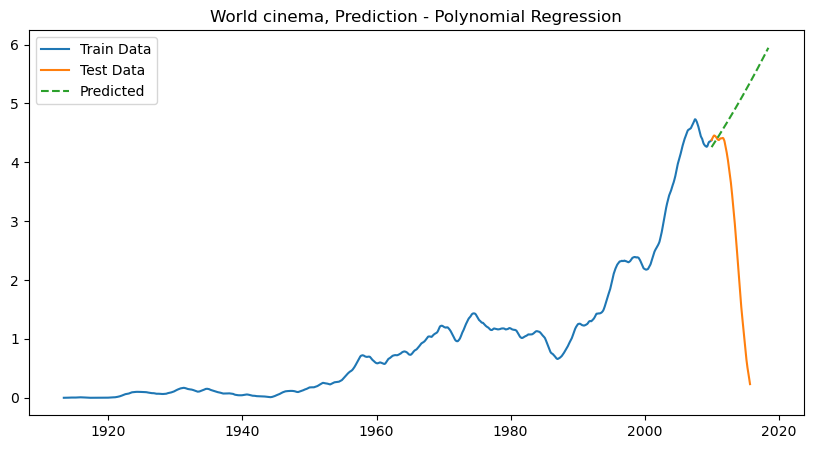

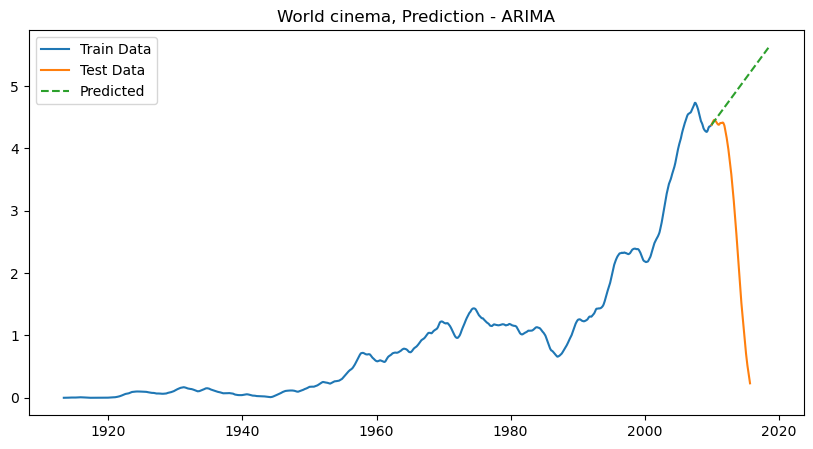

In [10]:
cutoff_year = 2000
prediction_length_days = 1000
polynomial_order = 3
arima_params = (20, 2, 20)

# Manually added this because some genres had problems with a single cutoff date
cutoff_years_by_genre = {
    'Action / Adventure': 2012,
    'Action': 2013,
    'Adventure': 2013,
    'Black-and-white': 2000,
    'Comedy film': 2014,
    'Comedy': 2010,
    'Crime Fiction': 2012,
    'Documentary': 2009,
    'Drama': 2012,
    'Family Film': 2013,
    'Horror': 2010,
    'Indie': 2010,
    'Musical': 2010,
    'Romance Film': 2012,
    'Romantic drama': 2008,
    'Short Film': 2013,
    'Silent film': 2000,
    'Thriller': 2012,
    'World cinema': 2010,
}

for genre, impact_series in timeseries_load_impact_by_genre.items():
    print(f"We are at genre: {genre}")

    if isinstance(impact_series, pd.DataFrame):
        impact_series = impact_series.iloc[:, 0]

    cutoff_date = pd.Timestamp(f'{cutoff_years_by_genre[genre]}-01-01')
    train = impact_series[impact_series.index < cutoff_date]
    test = impact_series[impact_series.index >= cutoff_date]

    tot_length_prediction = len(test) + prediction_length_days

    poly_predictions = polynomial_regression(train, degree = polynomial_order, n_forecast = tot_length_prediction)
    plot_results(train, test, poly_predictions, f"{genre}, Prediction - Polynomial Regression")

    arima_predictions = arima(train, order = arima_params, n_forecast = tot_length_prediction)
    plot_results(train, test, arima_predictions, f"{genre}, Prediction - ARIMA")


We save the predictions so that we don't need to run all this code again

In [15]:
all_predictions = []

for genre, impact_series in timeseries_load_impact_by_genre.items():
    poly_pred_df = pd.DataFrame({
        'Date': pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods = tot_length_prediction),
        'Genre': genre,
        'Model': 'Polynomial Regression',
        'Prediction': poly_predictions
    })
    all_predictions.append(poly_pred_df)

    arima_df = pd.DataFrame({
        'Date': pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods = tot_length_prediction),
        'Genre': genre,
        'Model': 'ARIMA',
        'Prediction': arima_predictions
    })
    all_predictions.append(arima_df)

final_predictions_df = pd.concat(all_predictions, ignore_index=True)
final_predictions_df.to_csv('./data/predictions.csv', index=False)